# Comment expliquer le prix de l'électricité (QRT challenge)

Contexte : Une multitude de facteurs influencent le prix de l'electricité au quotidien. Des variations locales du climat pourront à la fois affecter la production et la demande électrique par exemple. Des phénomènes à plus long terme, comme le réchauffement climatique, auront également un impact évident. Des évènements géopolitiques, comme la guerre en Ukraine, peuvent en parallèle faire bouger le prix des matières premières qui sont clefs dans la production d'électricité, sachant que chaque pays s'appuie sur un mix énergétique qui lui est propre (nucléaire, solaire, hydrolique, gaz, charbon, etc). De plus chaque pays peut importer/exporter de l'électricité avec ses voisins au travers de marchés dynamiques, comme en Europe. Ces différents élements rendent assez complexe la modélisation du prix de l'électricité par pays. <br>
<br>
**But** : modéliser le prix l'électricité à partir de données météorologiques, énergétiques (matières premières) et commerciales pour deux pays européens - la France et l'Allemagne. <br>
Attention : c'est ici un problème d'explication des prix par d'autres variables concomitantes et non pas un problème de prédiction. <br> 
> Plus précisément le but est de construire un modèle qui, à partir de ces variables explicatives, renvoie une bonne estimation de la variation journalière du prix de contrats à terme (dits futures) sur l'électricité, en France ou en Allemagne. Ces contrats permettent d'acheter (ou de vendre) une quantité donnée d'électricité à un prix fixé par le contrat et qui sera livrée à une date future spécifiée (maturité du contrat). Les futures sont donc des instruments financiers qui donnent une estimation de la valeur de l'électricité au moment de la maturité du contrat à partir des conditions actuelles du marché - ici, on se restreint à des futures à courte maturité (24h). Soulignons que l'échange de futures sur l'electricité est un marché dynamique en Europe. 

La fonction de score (métrique) utilisée est la corrélation de Spearman entre la réponse du participant et les variations réelles du prix des futures contenues dans le jeu de données de test. La corrélation de Spearman est une mesure de dépendance statistique non paramétrique entre deux variables. Plus précisement, pour un échantillon de taille $n$, les variables de rang $rg X_i$ et $rg Y_i$ sont calculées à partir de $X_i$ et $Y_i$. La corrélation de Spearman est définie par : $r_s = \frac{ \text{cov}( rg_{X}, rg_{Y} )}{ \sigma _{rg_{X}} \sigma _{rg_{Y}} }$. 

## Description des données : 

La colonne ID de X_train et Y_train est identique, et de même pour les données test. Les données d'entrainement fournissent 1494 lignes, et les données de test en contiennent 654.
NB : Les données d'entrée X_train et X_test représentent les même variables explicatives mais sur deux périodes de temps différentes. <br>
<br>
<br>
**Données d'entrée** (35 colonnes): <br>
<br>
- ID : Identifiant d'indexe unique, associé à un jour (DAY_ID) et un pays (COUNTRY) <br>
- DAY_ID : Identifiant du jour - les dates ont été annonymisées en préservant la structure des données <br>
- COUNTRY : Identifiant du pays - DE = Allemagne, FR = France <br>
<br>
et composées ensuite de variations journalières du prix de matières premières, <br>
- GAS_RET : Gaz en Europe <br>
- COAL_RET : Charbon en Europe <br>
- CARBON_RET : Futures sur les emissions carbone <br>
<br>
de mesures météorologiques (journalières, dans le pays x),
- x_TEMP : Temperature <br>
- x_RAIN : Pluie <br>
- x_WIND : Vent <br>
<br>
de mesures de productions d'energie (journalière, dans le pays x),
- x_GAS : Gaz naturel <br>
- x_COAL : Charbon <br>
- x_HYDRO : Hydrolique <br>
- x_NUCLEAR : Nucléaire <br>
- x_SOLAR : Photovoltaïque <br>
- x_WINDPOW : Eolienne <br>
- x_LIGNITE : Lignite <br>
<br>
et de mesures d'utilisation électrique (journalières, dans le pays x),
- x_CONSUMPTON : Electricité totale consommée <br>
- x_RESIDUAL_LOAD : Electricité consommée après utilisation des énergies renouvelables <br>
- x_NET_IMPORT: Electricité importée depuis l'Europe <br>
- x_NET_EXPORT: Electricité exportée vers l'Europe <br>
- DE_FR_EXCHANGE: Electricité échangée entre Allemagne et France <br>
- FR_DE_EXCHANGE: Electricité échangée entre France et Allemagne. <br>
<br>
<br>
**Données de sortie** (2 colonnes):
- ID : Identifiant unique - le même que celui des données d'entrée <br>
- TARGET : Variation journalière du prix de futures d'électricité (maturité 24h). <br>
<br>
<br>
**Description du benchmark** <br>
Le benchmark pour ce challenge consiste en une simple régression linéaire, après un léger nettoyage des données : les valeurs manquantes (NaN) ont été remplacées par des zéros et la colonne COUNTRY a été supprimée - en d'autres termes, nous avons utilisé un modèle identique pour la France et l'Allemagne. <br>
<br>
Le score public obtenu pour ce benchmark est de 15.86%. Un notebook contenant la génération du benchmark et quelques discussions est disponible en "supplementary files" que vous trouverez sur cette page (colonne de droite).


In [1]:
# imports 

import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt 
import seaborn as sns 
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.pipeline import make_pipeline

In [2]:
X_train = pd.read_csv('X_train_NHkHMNU.csv')
y_train = pd.read_csv('y_train_ZAN5mwg.csv')
X_test = pd.read_csv('X_test_final.csv')
y_test = pd.read_csv('y_test_random_final.csv')

In [3]:
# Trier les colonnes par catégories 

id_columns = ['ID', 'DAY_ID', 'COUNTRY']

mp_columns = ['GAS_RET', 'COAL_RET', 'CARBON_RET']

meteo_columns = ['DE_RAIN', 'FR_RAIN', 'DE_WIND','FR_WIND', 'DE_TEMP', 'FR_TEMP']

energie_columns = ['DE_GAS', 'FR_GAS', 'DE_COAL','FR_COAL', 'DE_HYDRO', 'FR_HYDRO', 'DE_NUCLEAR',
       'FR_NUCLEAR','DE_SOLAR', 'FR_SOLAR', 'DE_WINDPOW', 'FR_WINDPOW', 'DE_LIGNITE']

mesure_columns = ['DE_CONSUMPTION', 'FR_CONSUMPTION','DE_FR_EXCHANGE', 'FR_DE_EXCHANGE', 
       'DE_NET_EXPORT', 'FR_NET_EXPORT','DE_RESIDUAL_LOAD', 'FR_RESIDUAL_LOAD' ]

In [4]:
print("Shape of X_train is : ", X_train.shape)

Shape of X_train is :  (1494, 35)


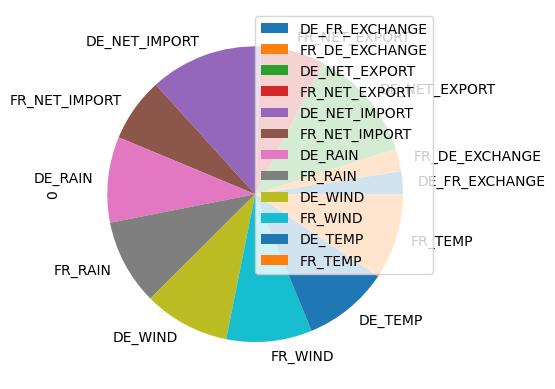

In [5]:
df_na = pd.DataFrame(np.sum(X_train.isna()), index = X_train.columns).replace({np.float64(0):np.nan}).dropna(axis=0)

df_na.plot.pie(subplots=True)
columns_with_na = list(df_na.index)

<AxesSubplot:>

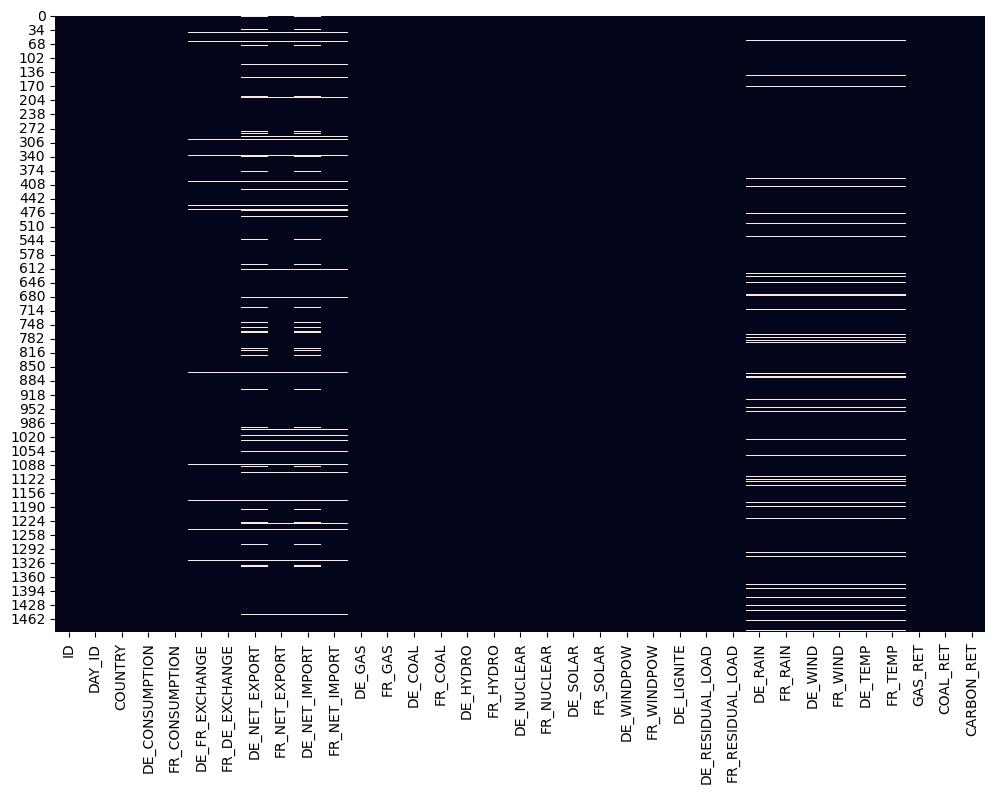

In [6]:
plt.figure(figsize = (12,8))
sns.heatmap(X_train.isna(), cbar = False)


Type of variables :  AxesSubplot(0.22375,0.11;0.5775x0.77)
int variable is :  ['ID', 'DAY_ID']
object variable is :  ['COUNTRY']


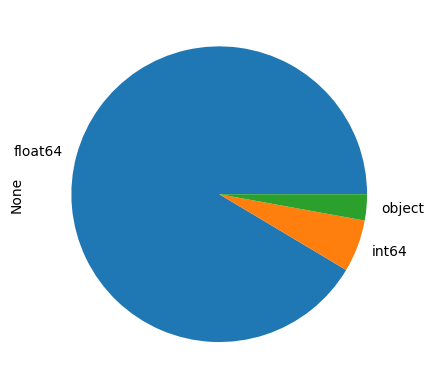

In [7]:
print("\nType of variables : ", X_train.dtypes.value_counts().plot.pie())

object_variables = list(X_train.select_dtypes('object').columns)
int_variables = list(X_train.select_dtypes('int64').columns)
float_variables = list(X_train.select_dtypes('float64').columns)

print("int variable is : ", int_variables)
print("object variable is : ", object_variables)

/Users/augustincablant/opt/anaconda3/lib/python3.9/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/Users/augustincablant/opt/anaconda3/lib/python3.9/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/Users/augustincablant/opt/anaconda3/lib/python3.9/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-l

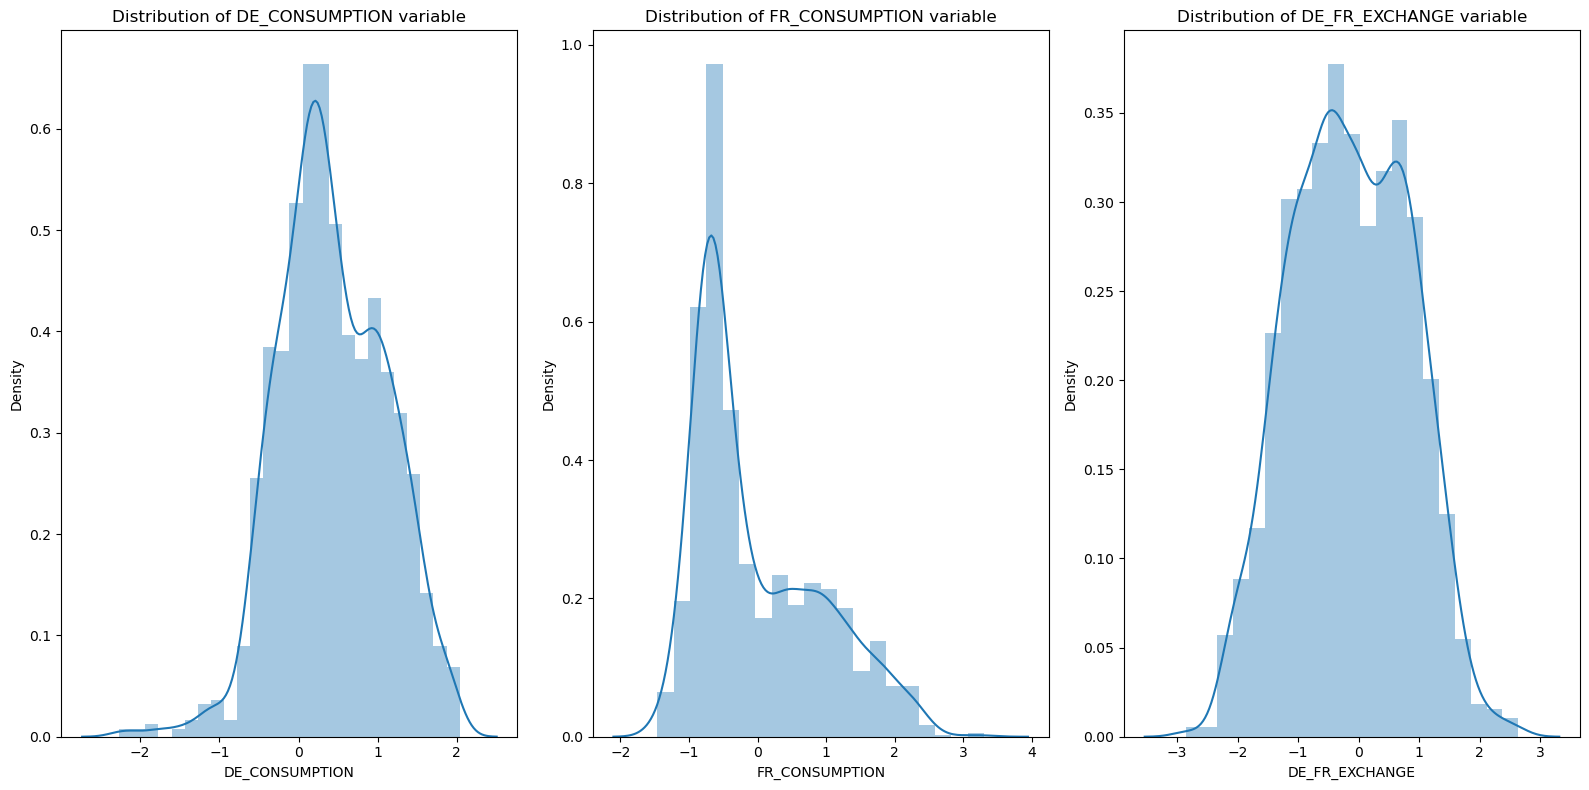

/Users/augustincablant/opt/anaconda3/lib/python3.9/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/Users/augustincablant/opt/anaconda3/lib/python3.9/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/Users/augustincablant/opt/anaconda3/lib/python3.9/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-l

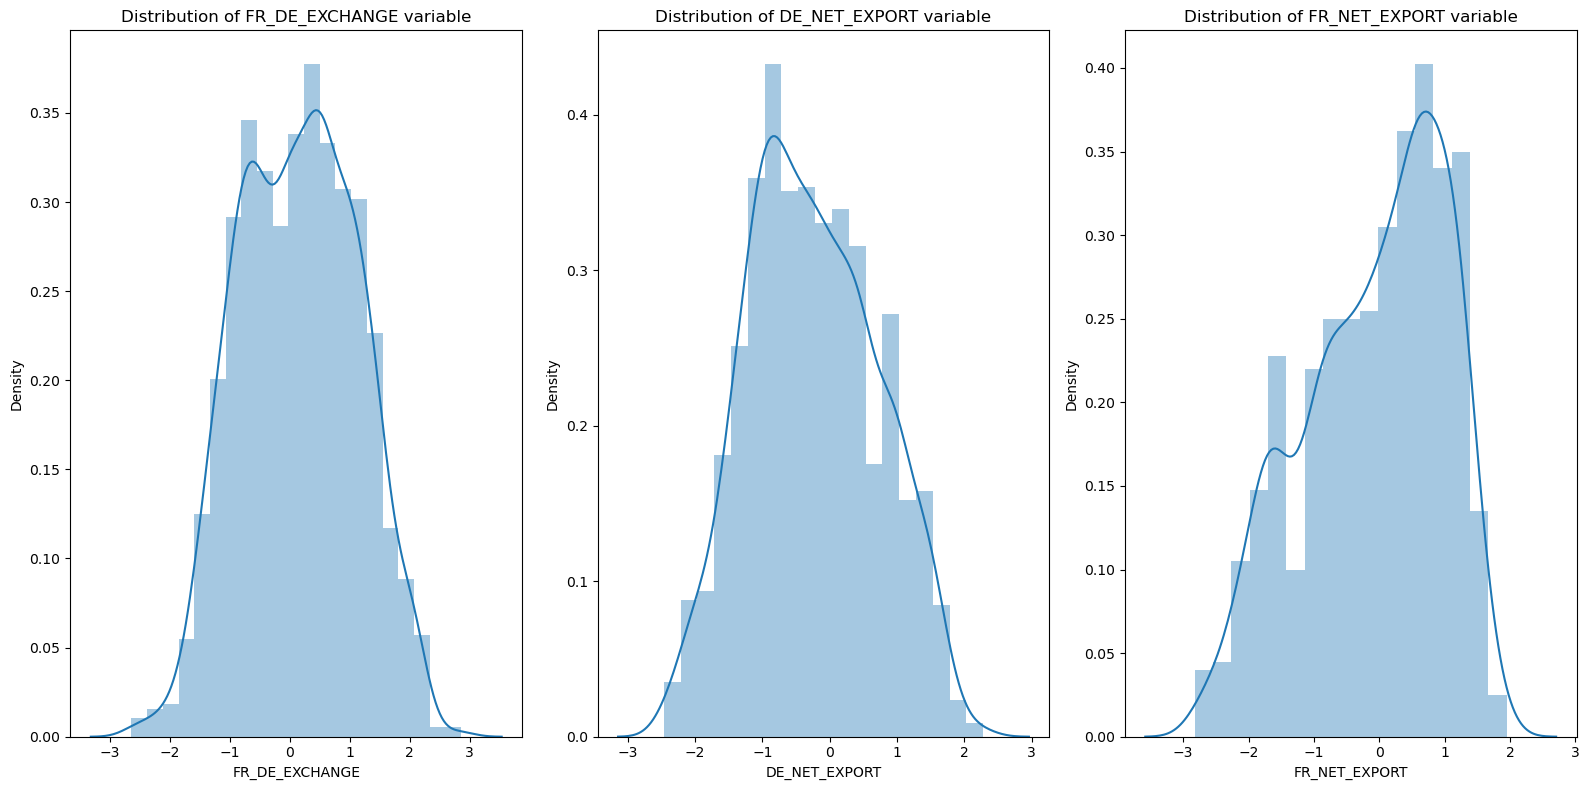

/Users/augustincablant/opt/anaconda3/lib/python3.9/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/Users/augustincablant/opt/anaconda3/lib/python3.9/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/Users/augustincablant/opt/anaconda3/lib/python3.9/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-l

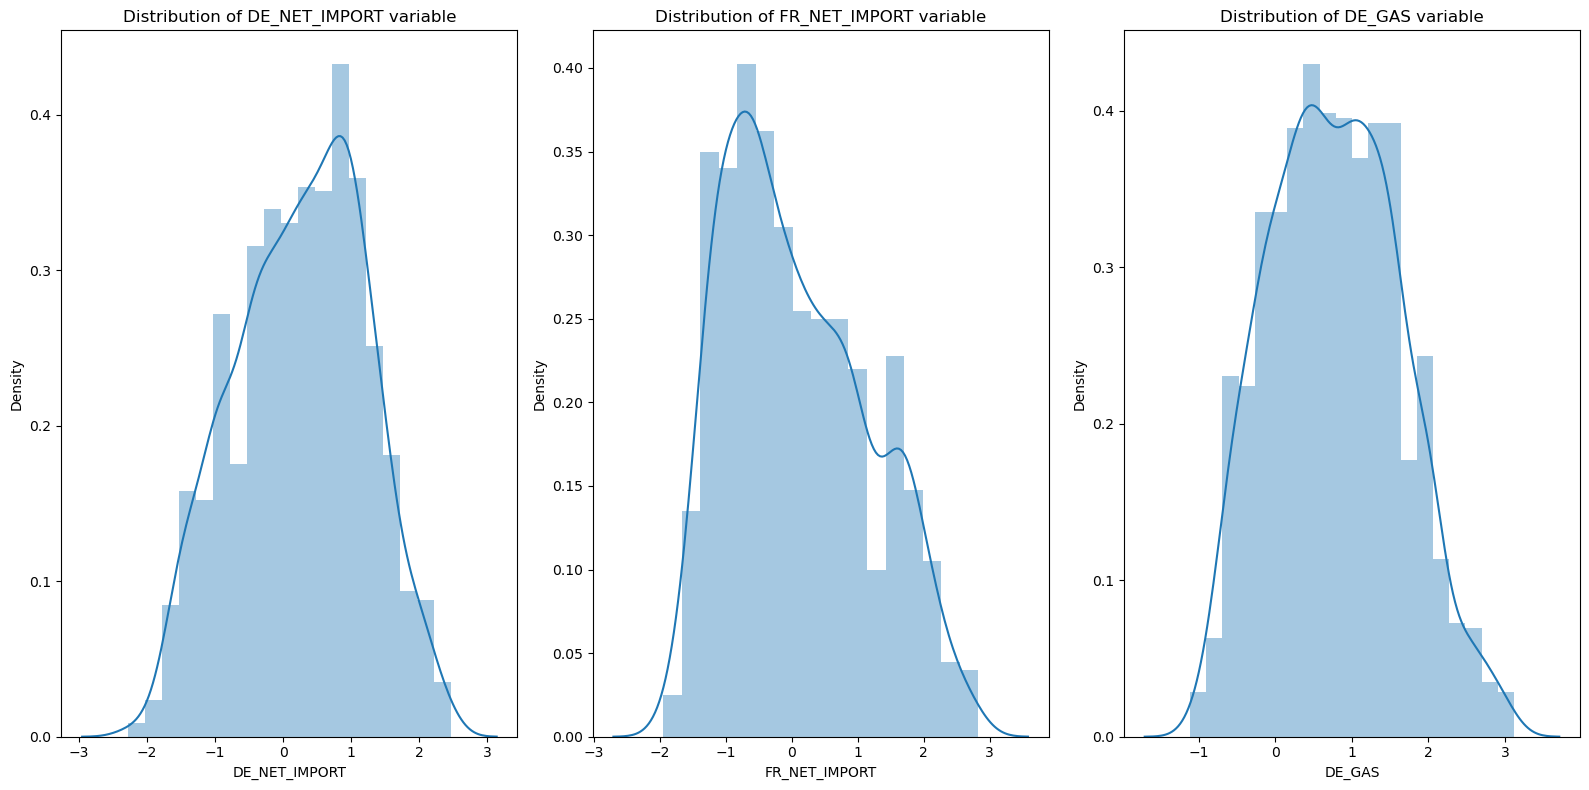

/Users/augustincablant/opt/anaconda3/lib/python3.9/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/Users/augustincablant/opt/anaconda3/lib/python3.9/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/Users/augustincablant/opt/anaconda3/lib/python3.9/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-l

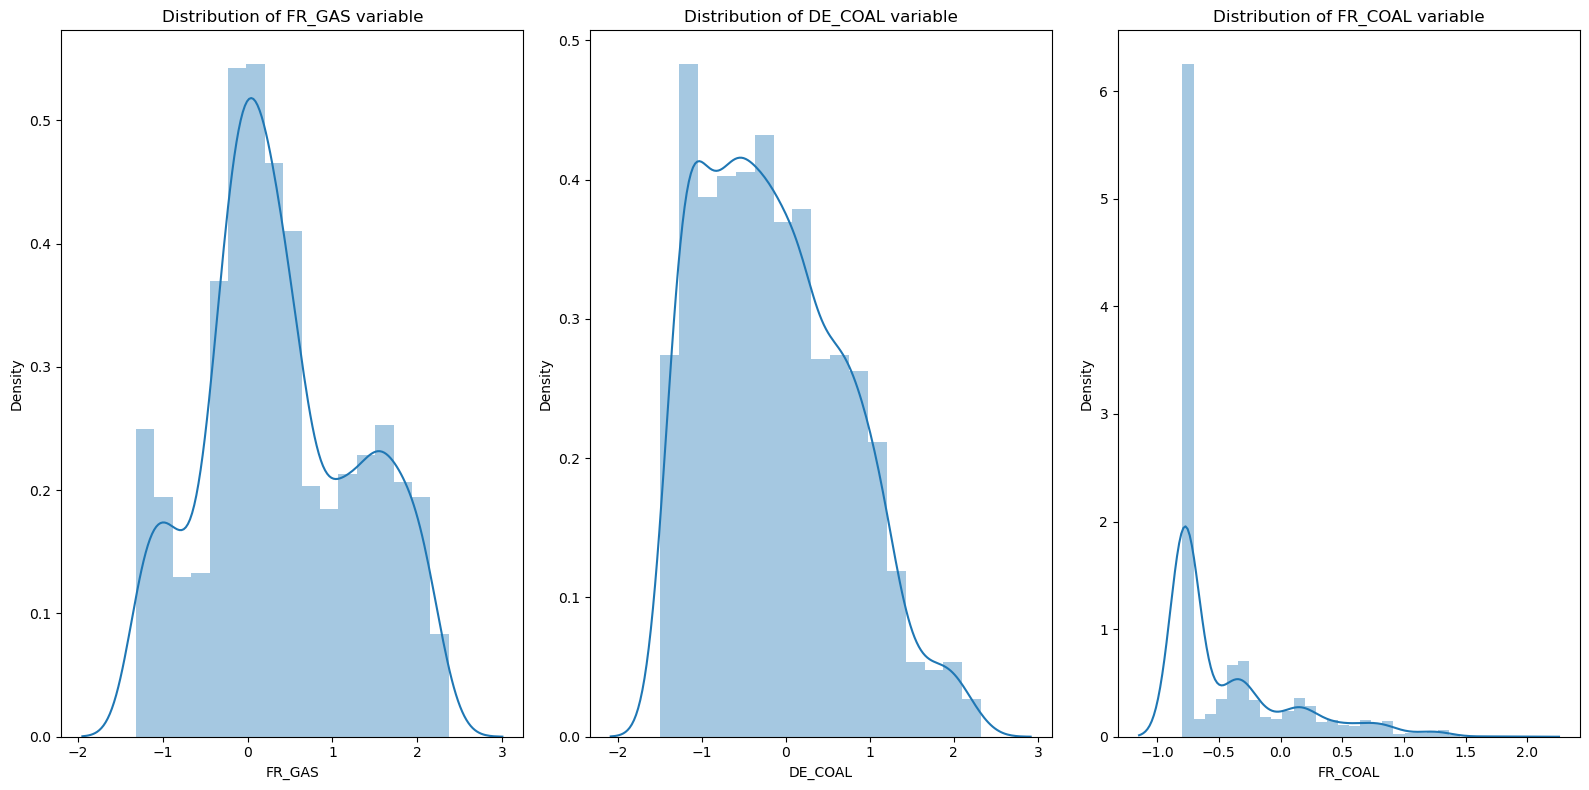

/Users/augustincablant/opt/anaconda3/lib/python3.9/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/Users/augustincablant/opt/anaconda3/lib/python3.9/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/Users/augustincablant/opt/anaconda3/lib/python3.9/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-l

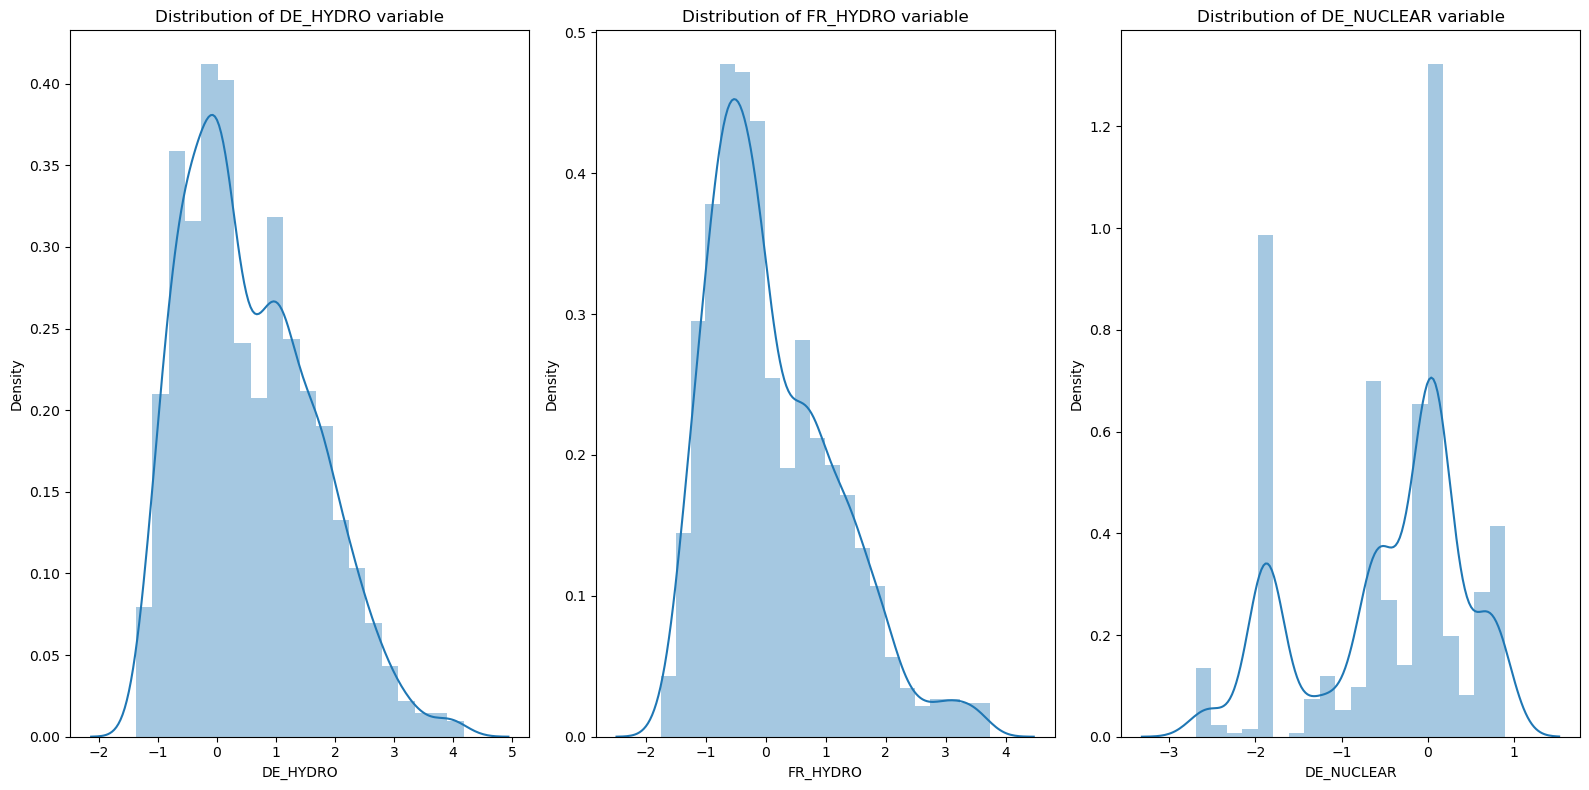

/Users/augustincablant/opt/anaconda3/lib/python3.9/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/Users/augustincablant/opt/anaconda3/lib/python3.9/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/Users/augustincablant/opt/anaconda3/lib/python3.9/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-l

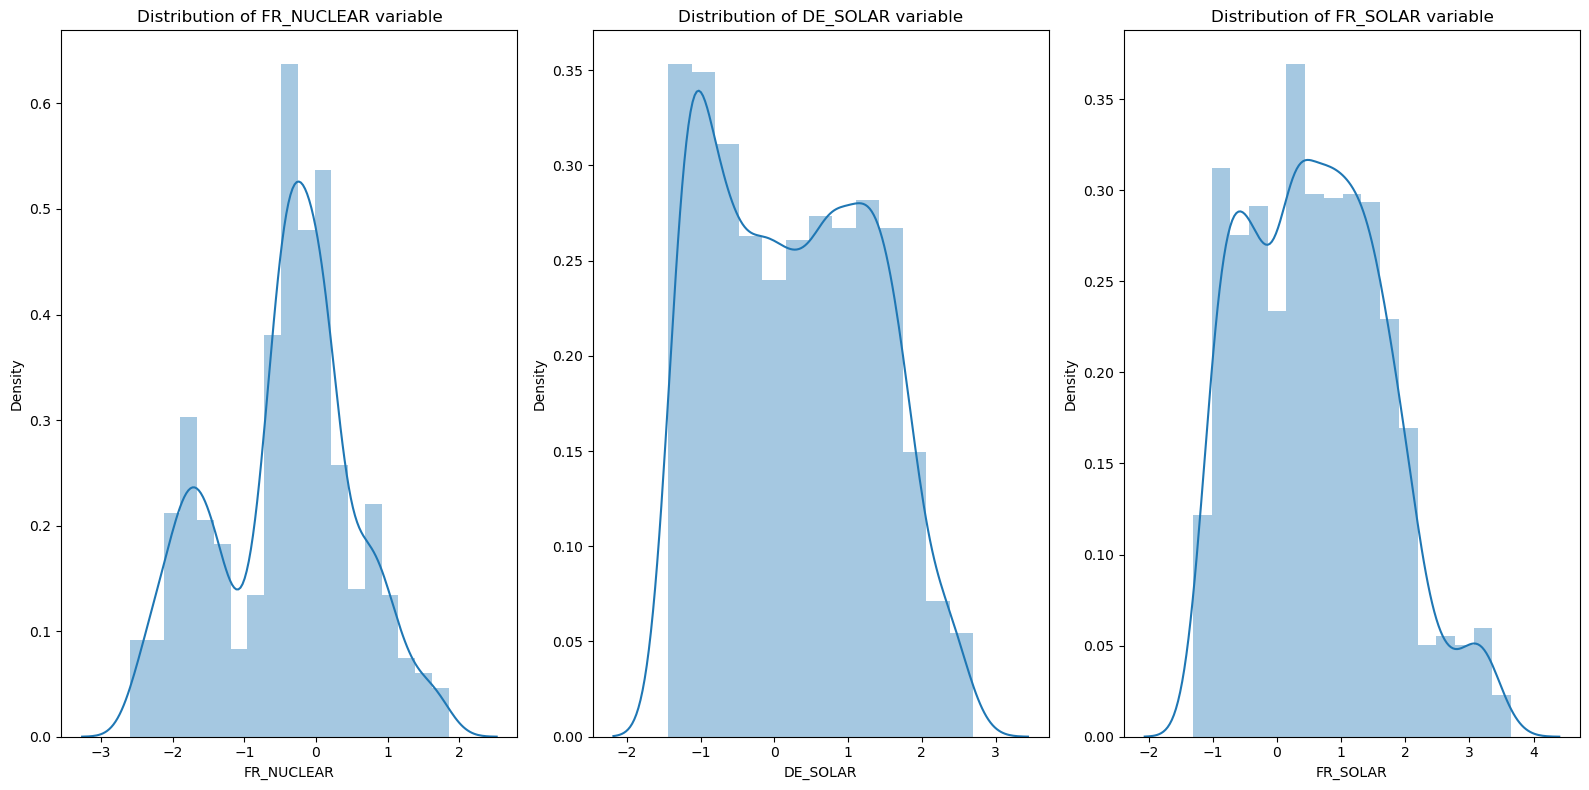

/Users/augustincablant/opt/anaconda3/lib/python3.9/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/Users/augustincablant/opt/anaconda3/lib/python3.9/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/Users/augustincablant/opt/anaconda3/lib/python3.9/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-l

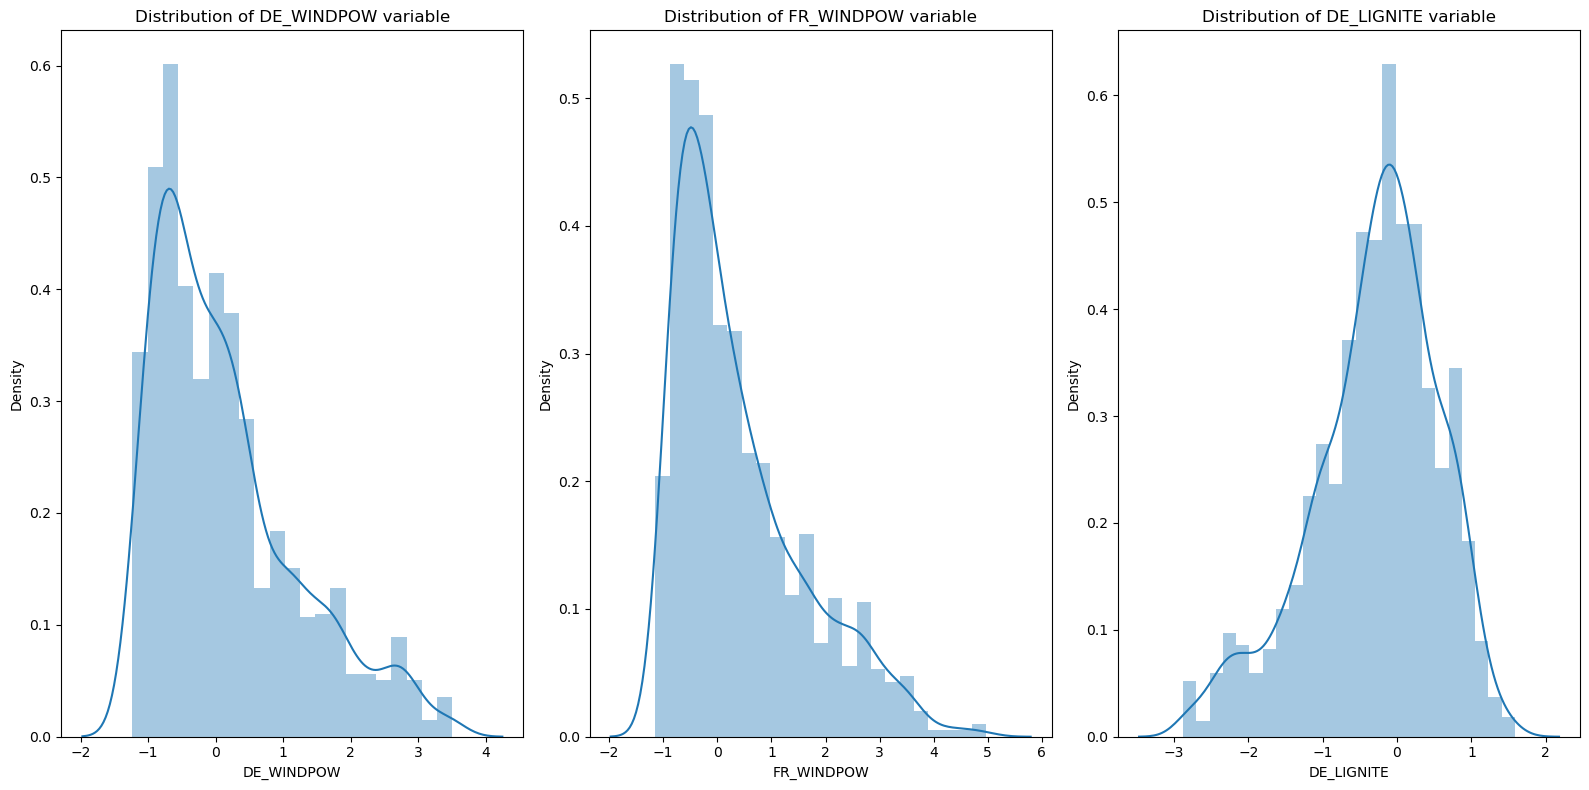

/Users/augustincablant/opt/anaconda3/lib/python3.9/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/Users/augustincablant/opt/anaconda3/lib/python3.9/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/Users/augustincablant/opt/anaconda3/lib/python3.9/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-l

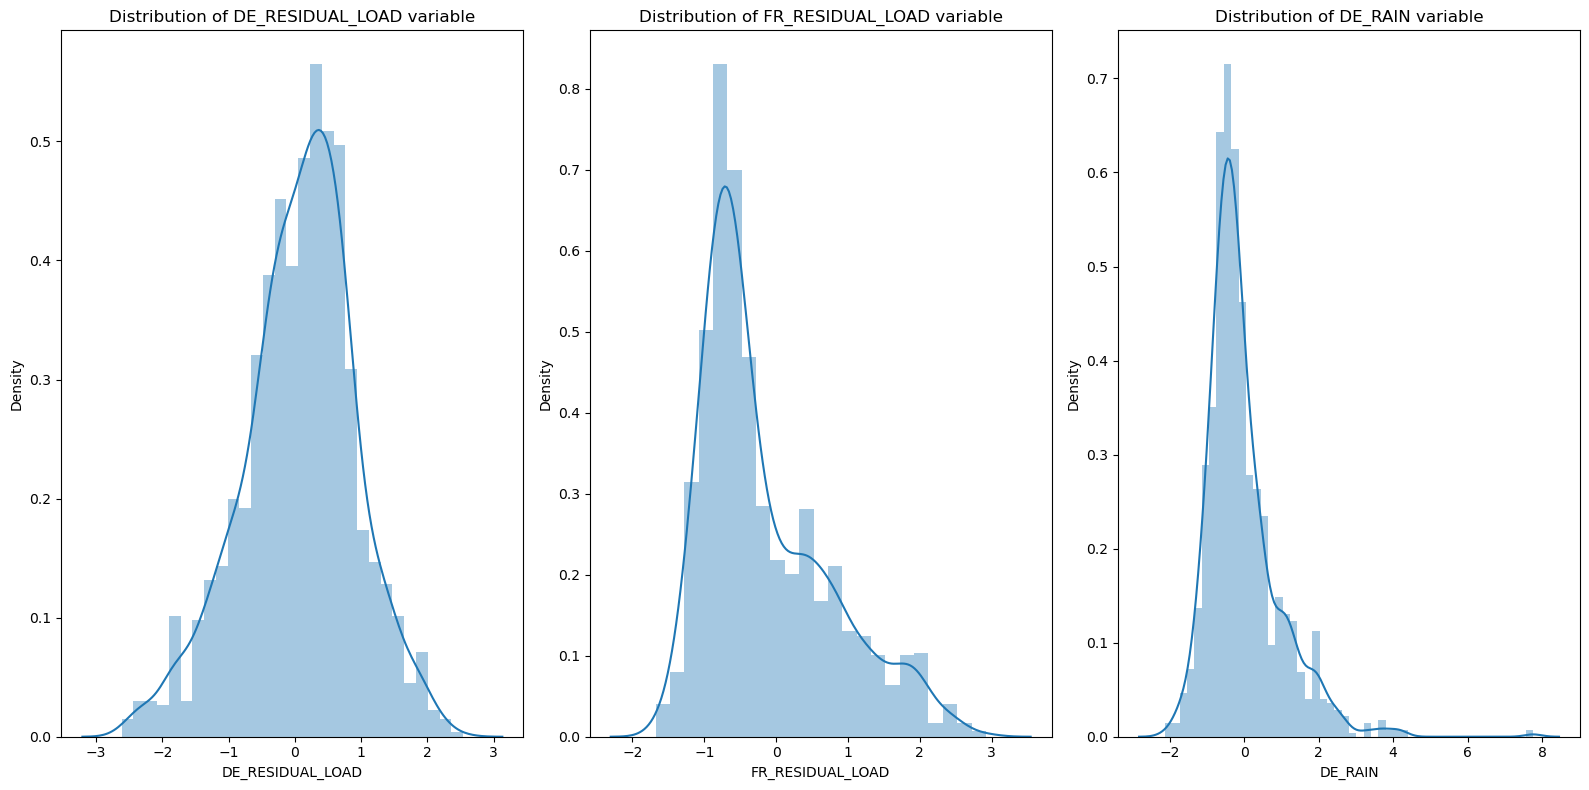

/Users/augustincablant/opt/anaconda3/lib/python3.9/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/Users/augustincablant/opt/anaconda3/lib/python3.9/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/Users/augustincablant/opt/anaconda3/lib/python3.9/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-l

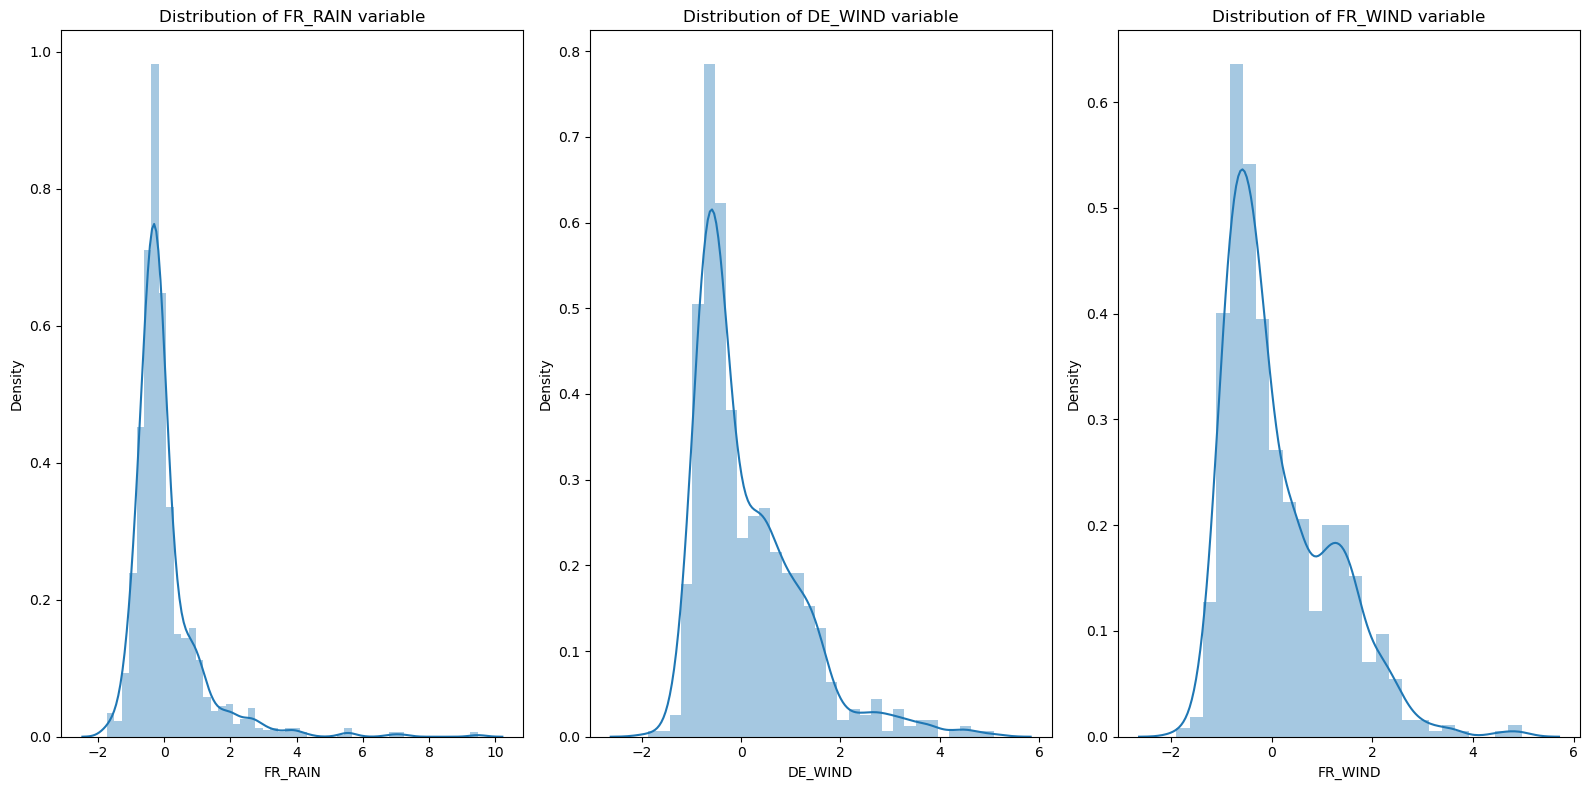

/Users/augustincablant/opt/anaconda3/lib/python3.9/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/Users/augustincablant/opt/anaconda3/lib/python3.9/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/Users/augustincablant/opt/anaconda3/lib/python3.9/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-l

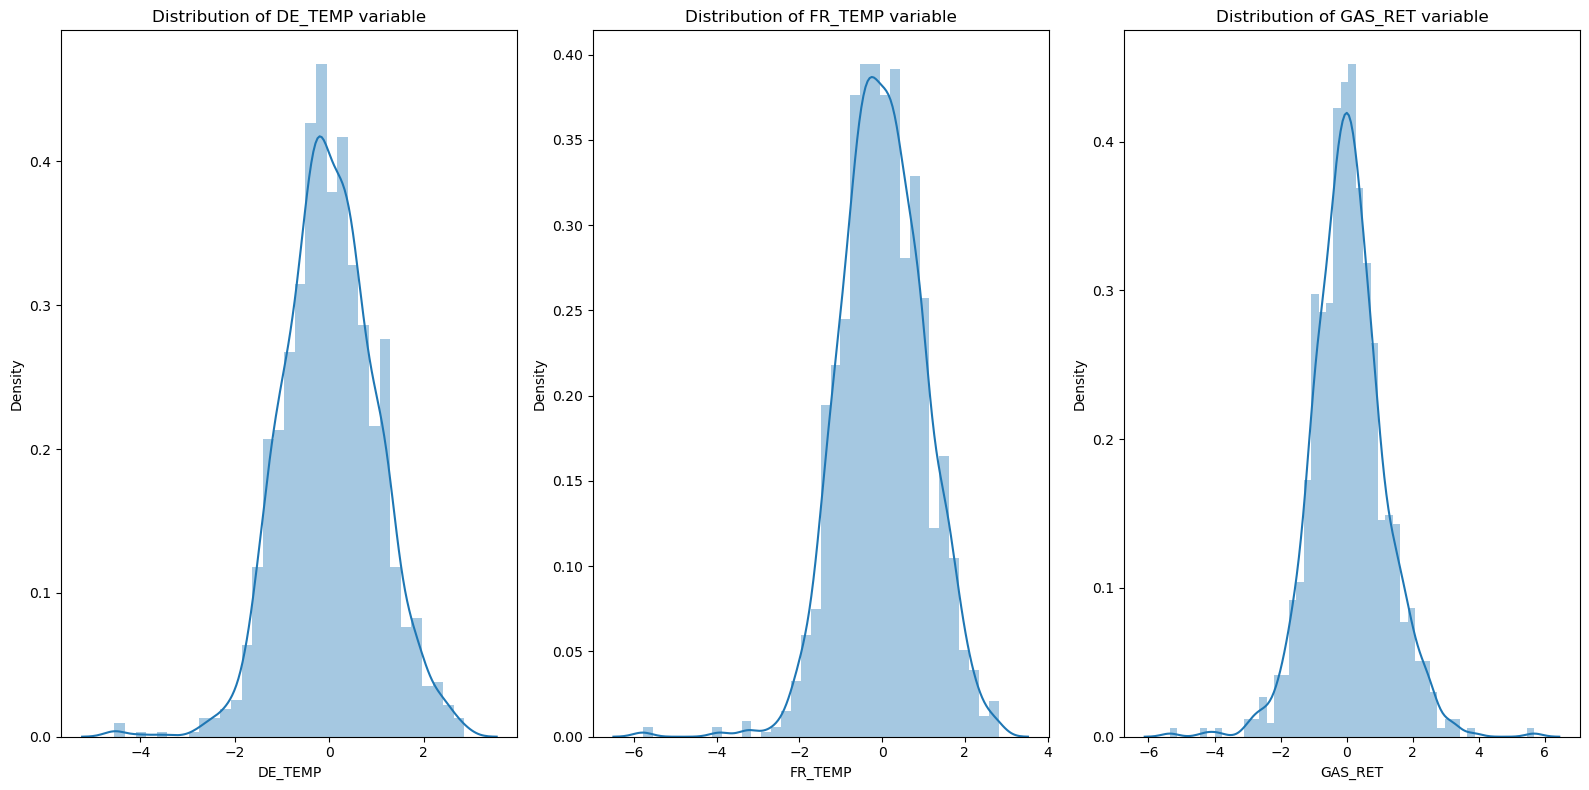

/Users/augustincablant/opt/anaconda3/lib/python3.9/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/Users/augustincablant/opt/anaconda3/lib/python3.9/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


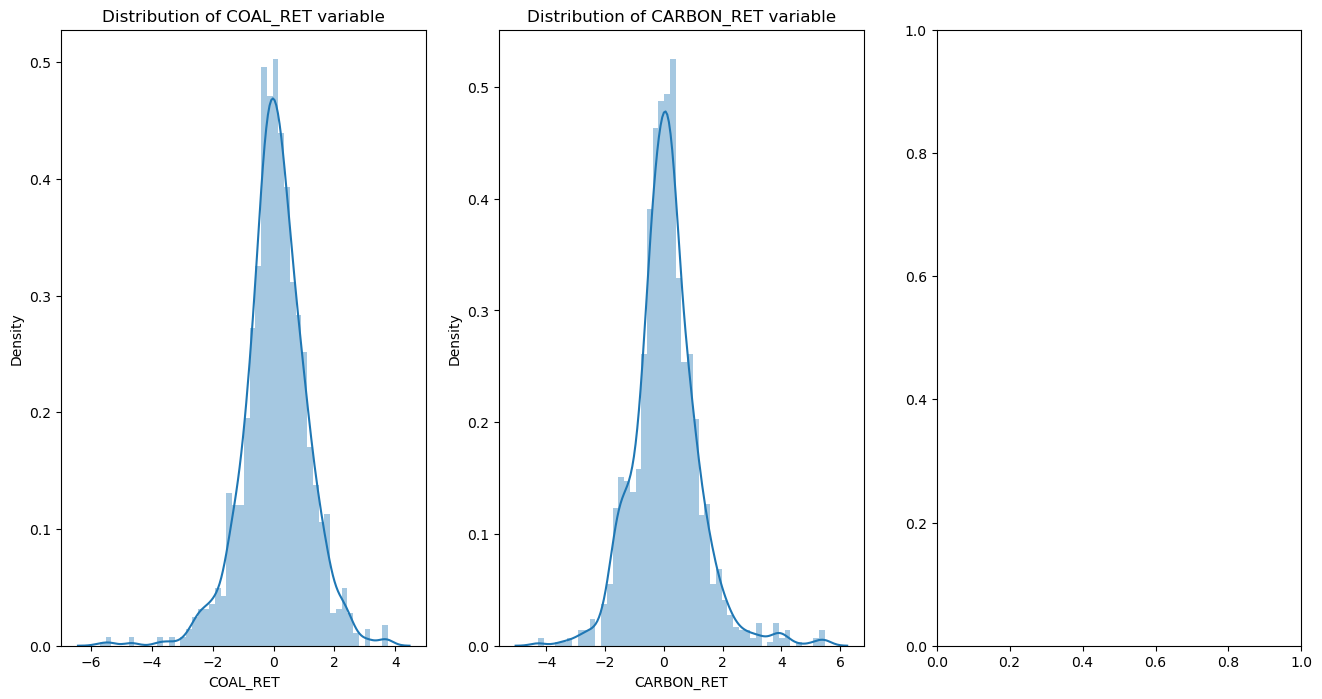

In [8]:
# histogram of continuous variables 

fig, axes = plt.subplots(1, 3, figsize=(16, 8))
axe = 0
for i, col in enumerate(float_variables):
    if axe>2:
        plt.tight_layout()
        plt.show()
        fig, axes = plt.subplots(1, 3, figsize=(16, 8))
        axe=0

    sns.distplot(X_train[col], ax=axes[axe])
    axes[axe].set_title(f'Distribution of {col} variable')
    axe +=1 

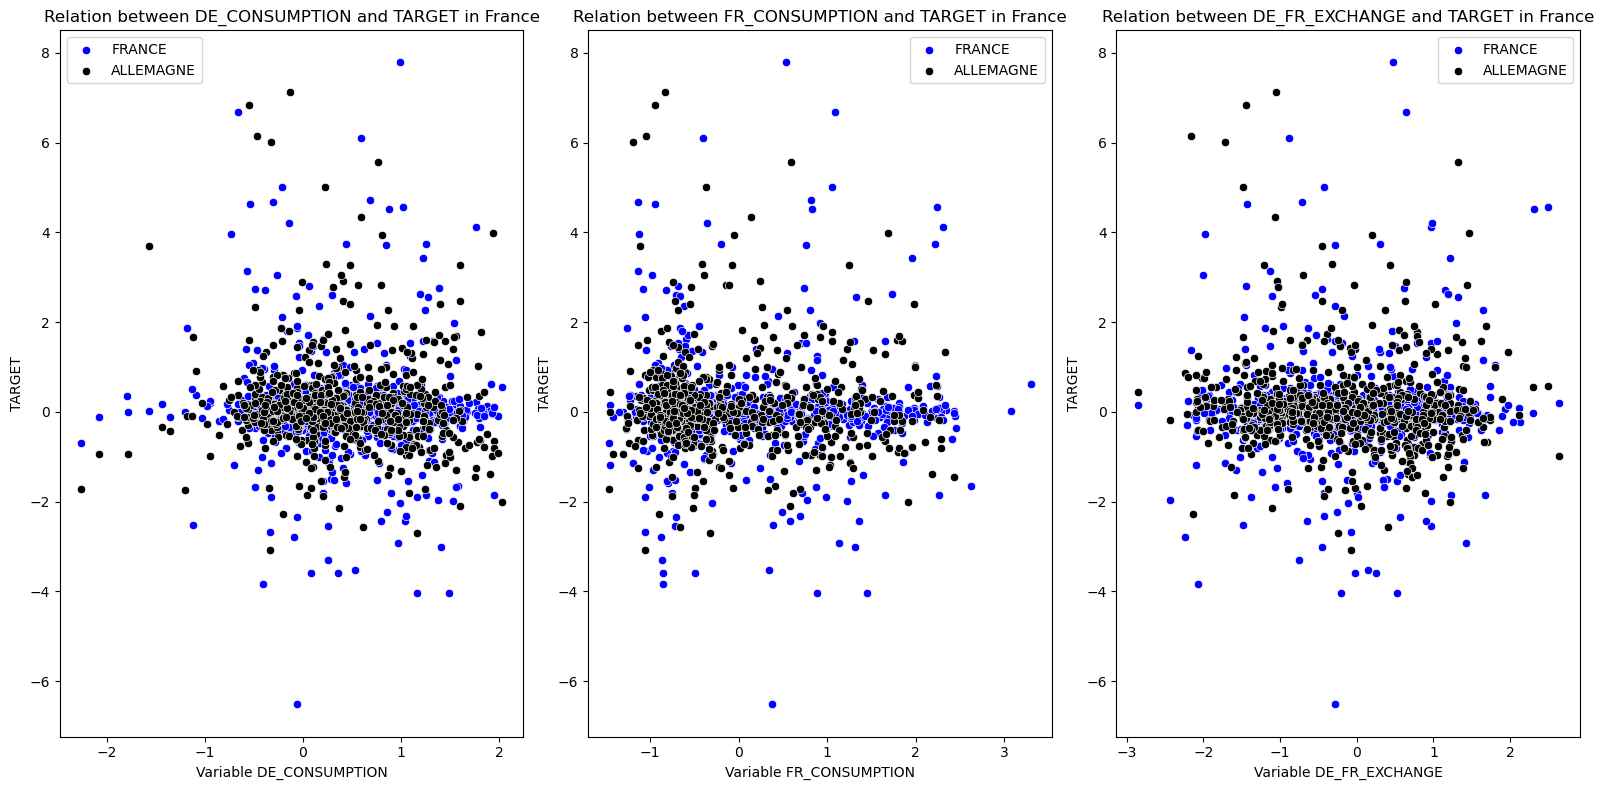

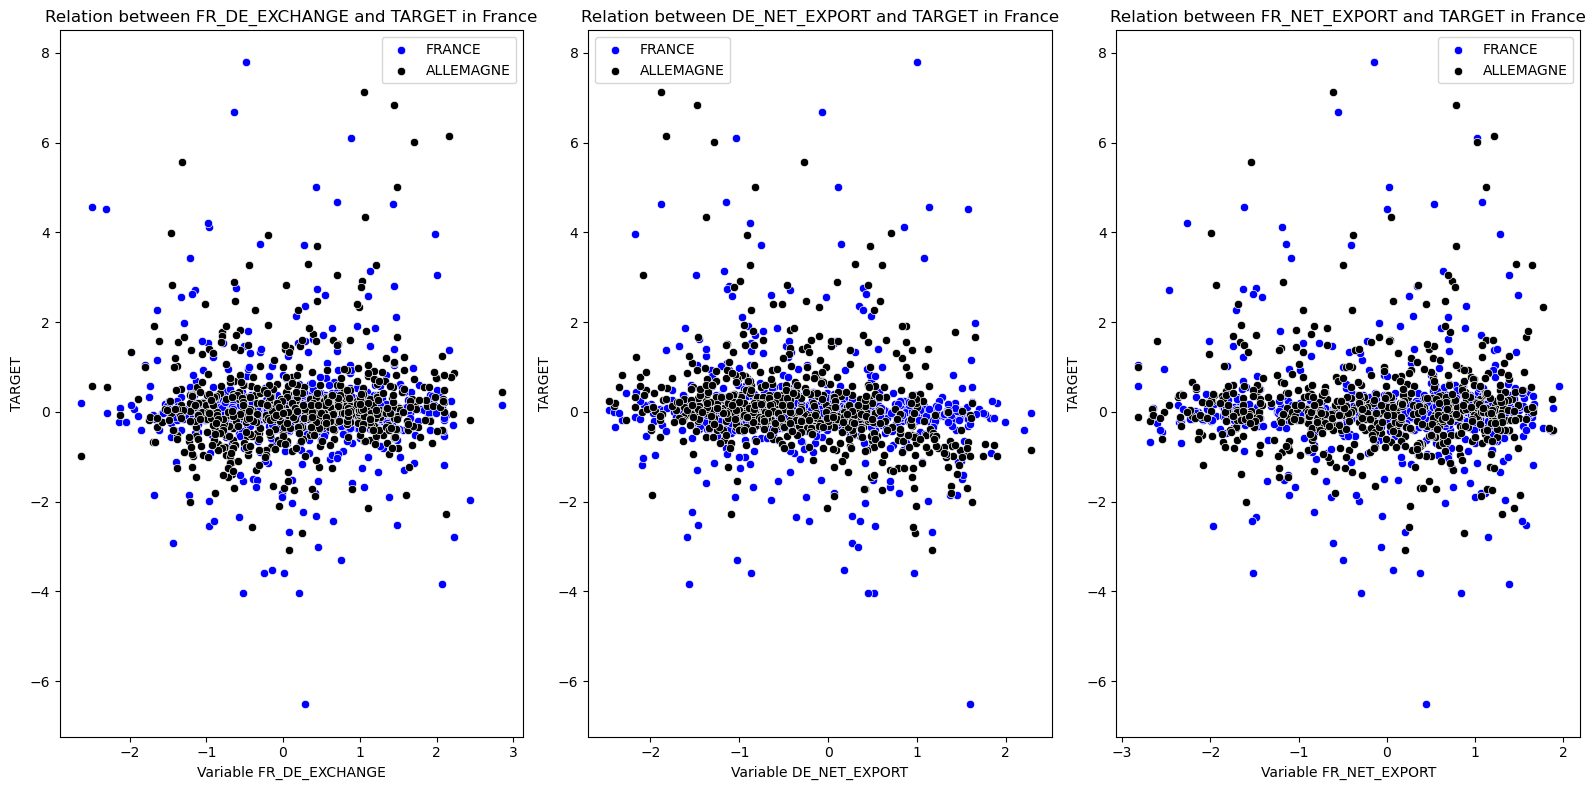

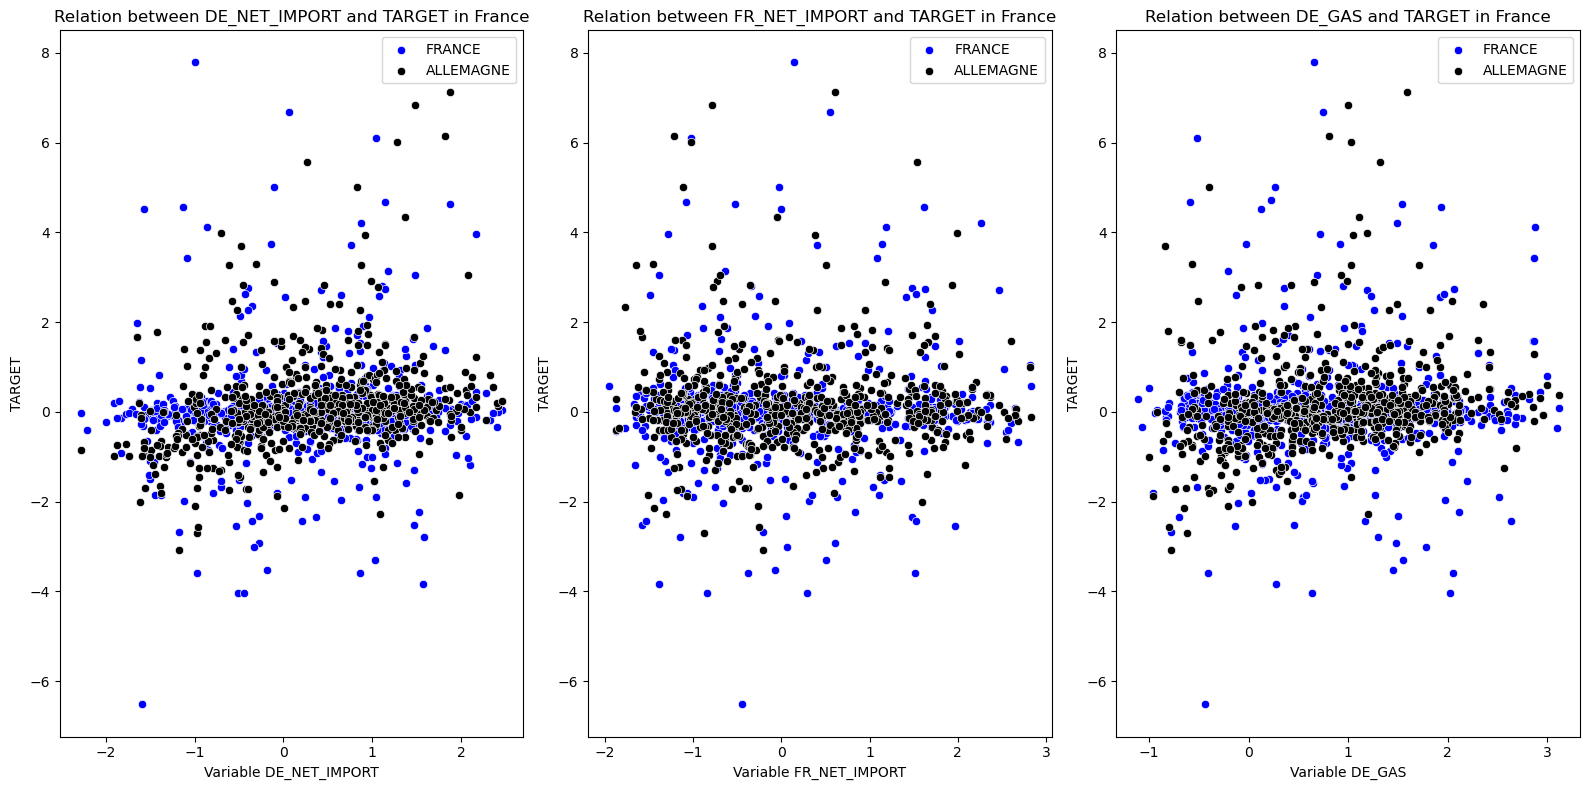

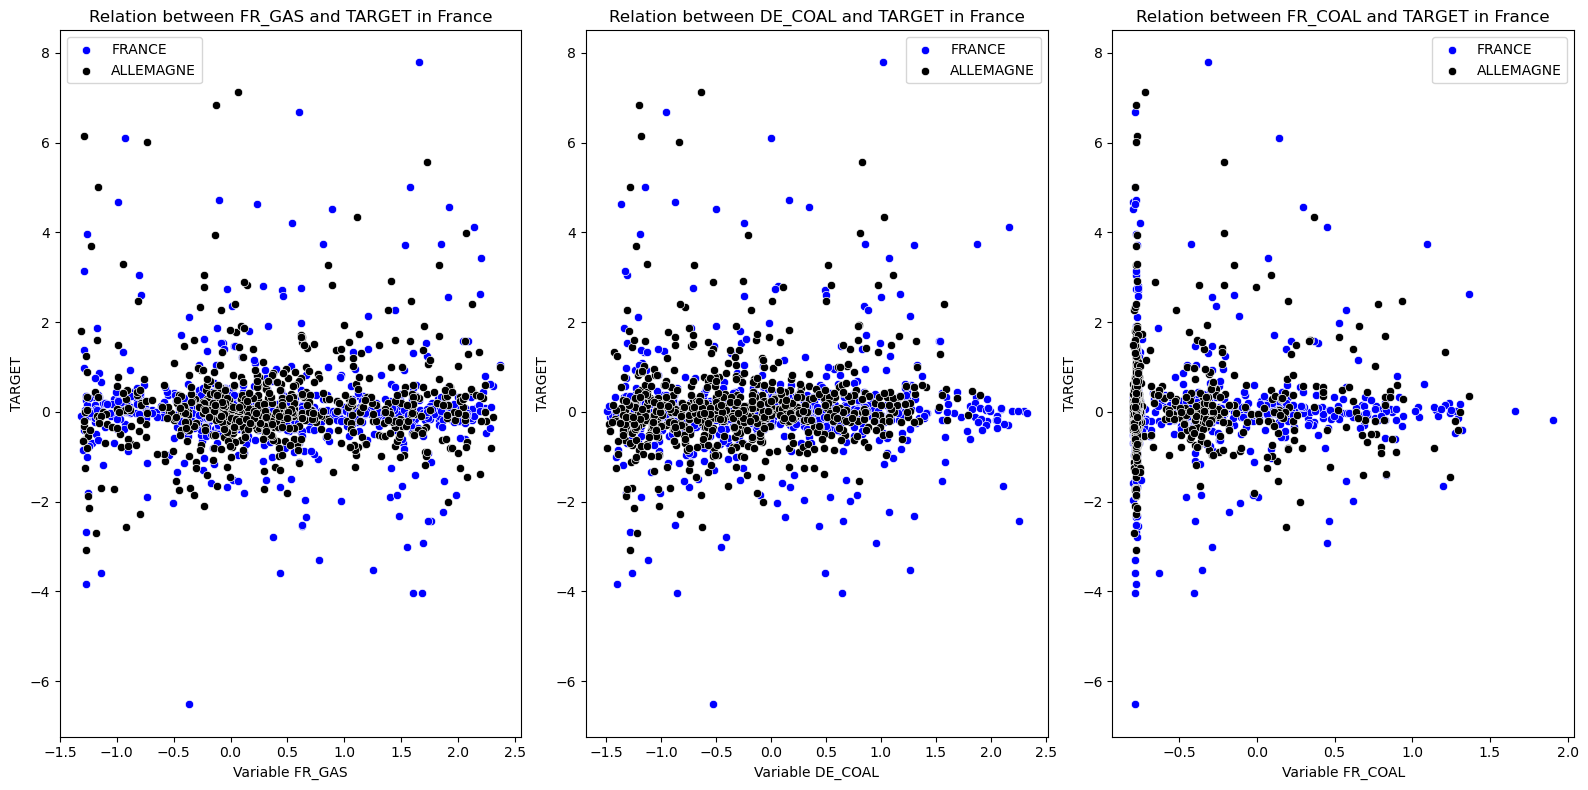

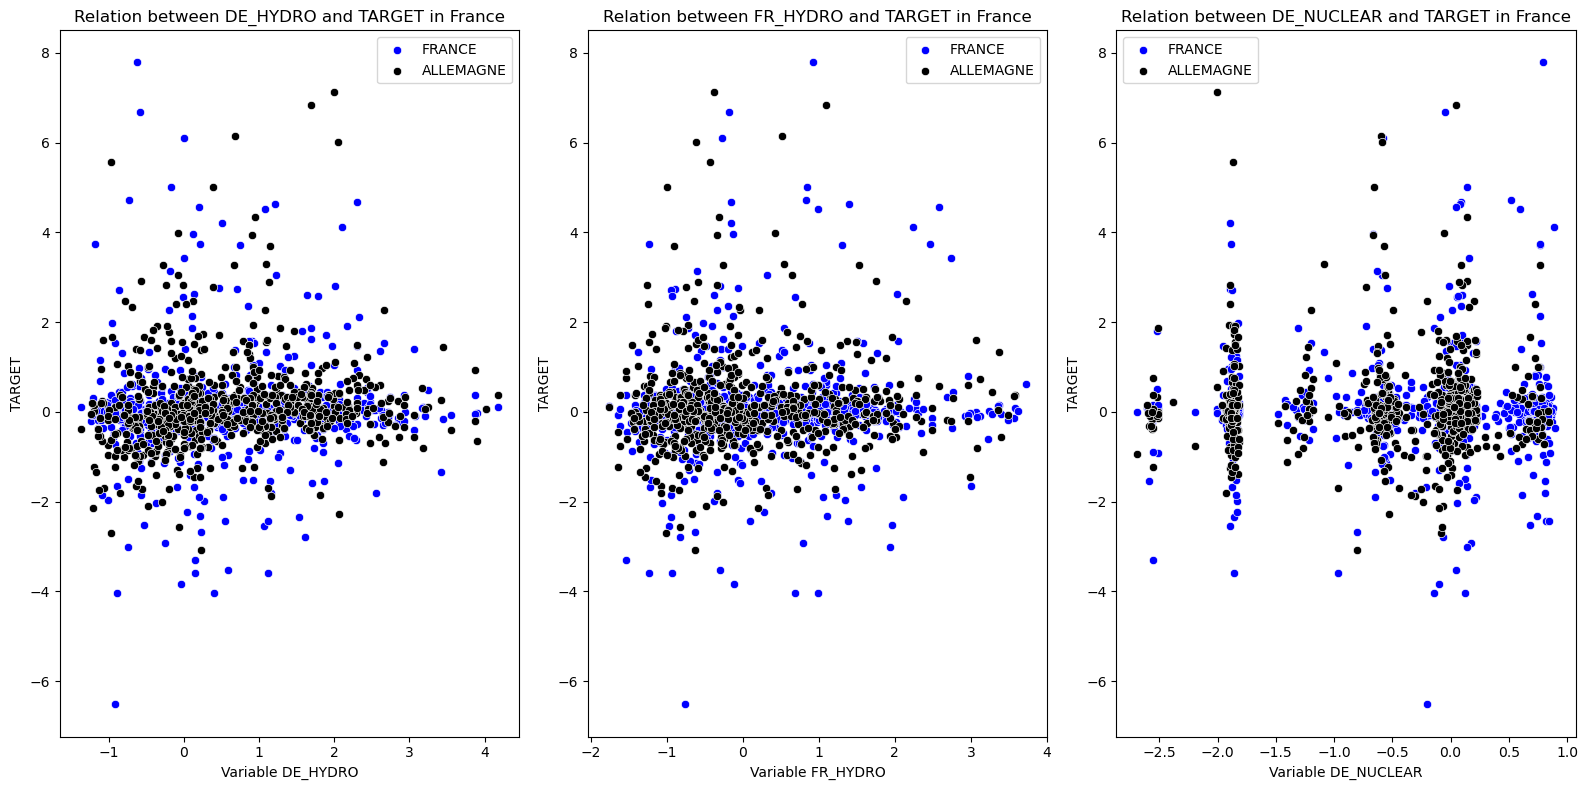

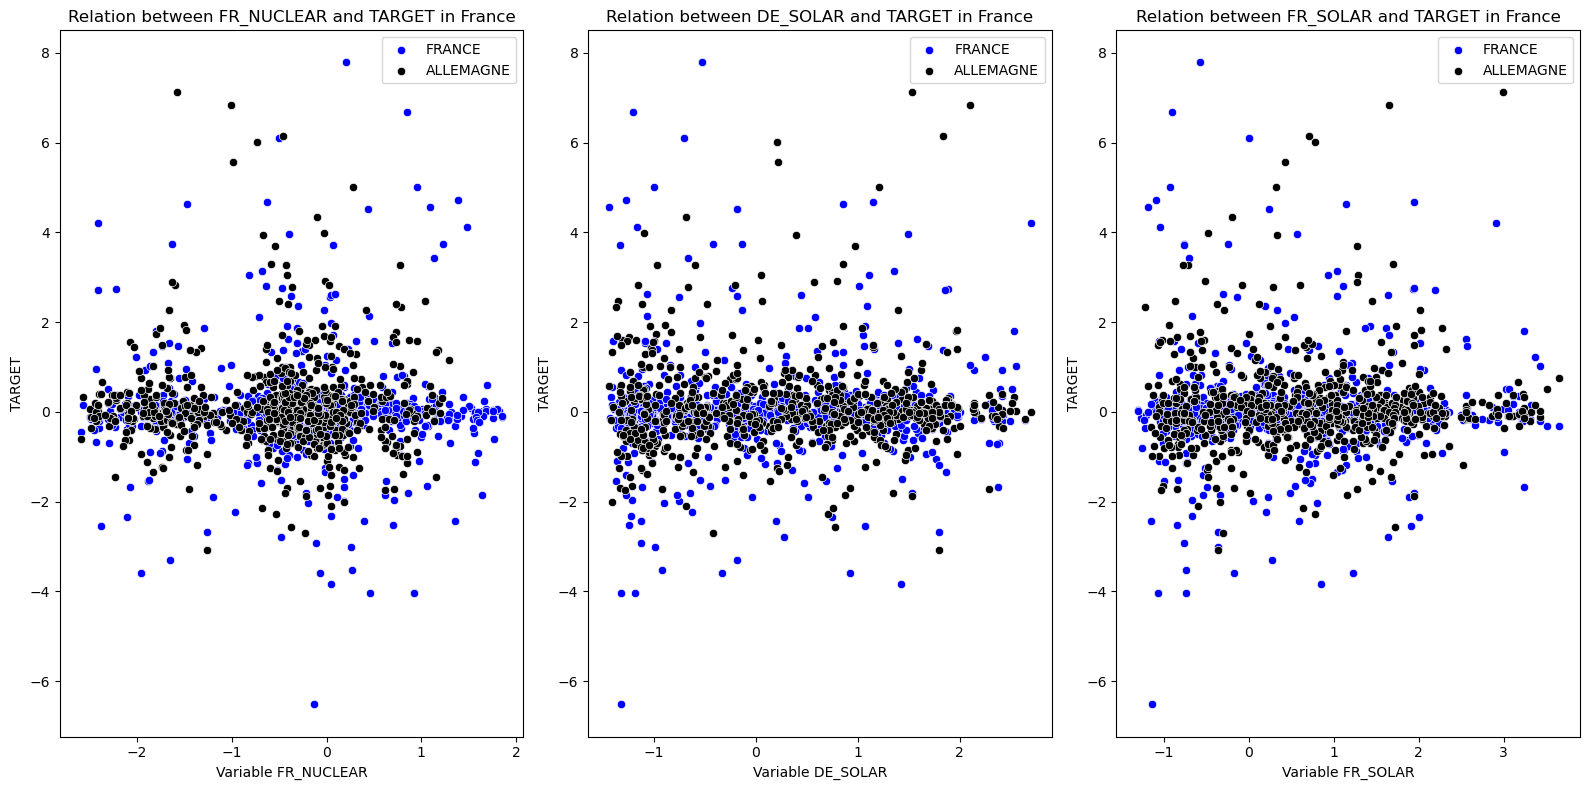

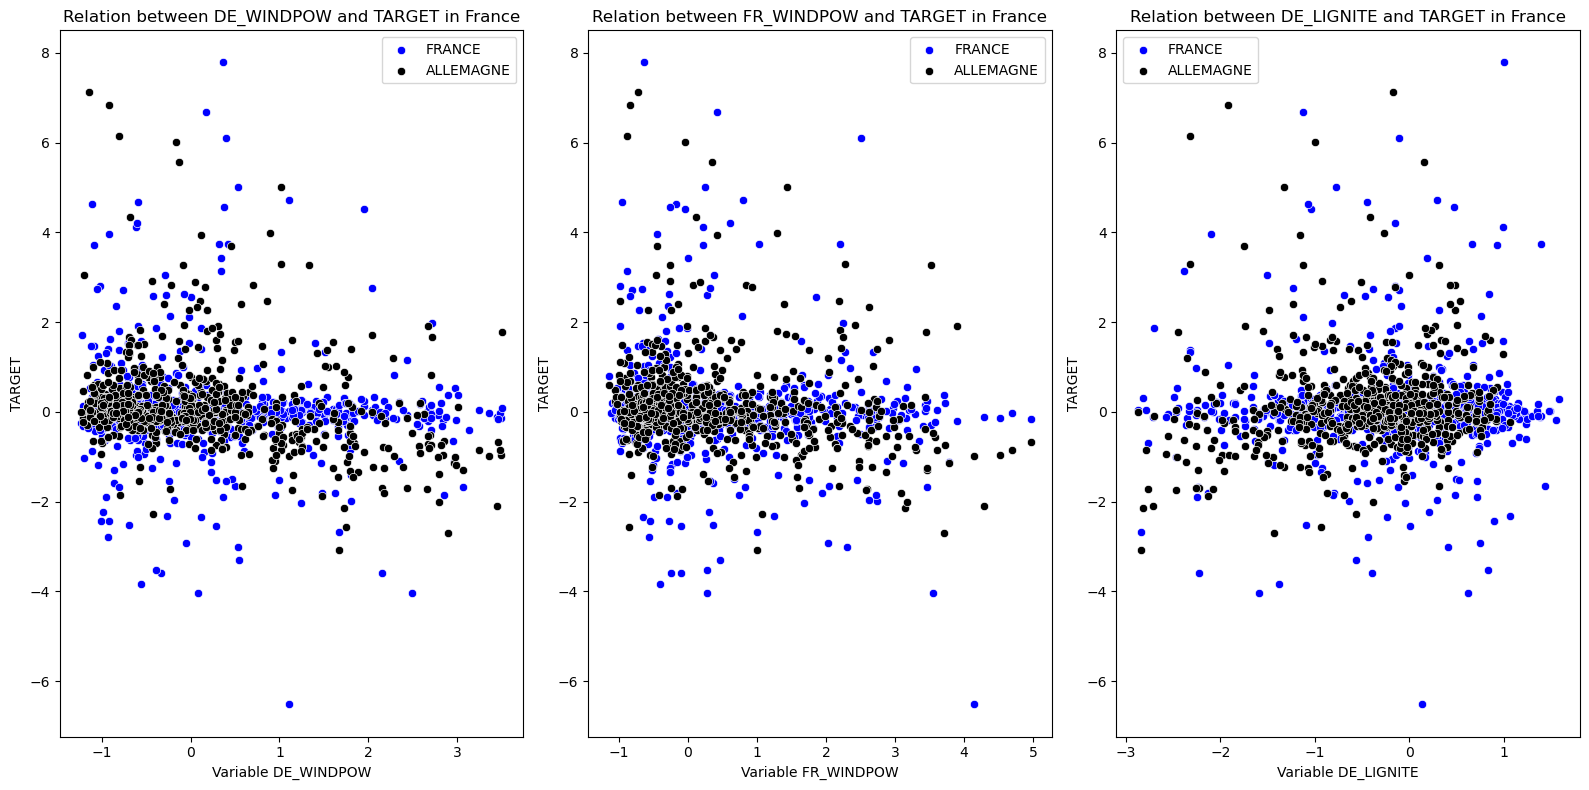

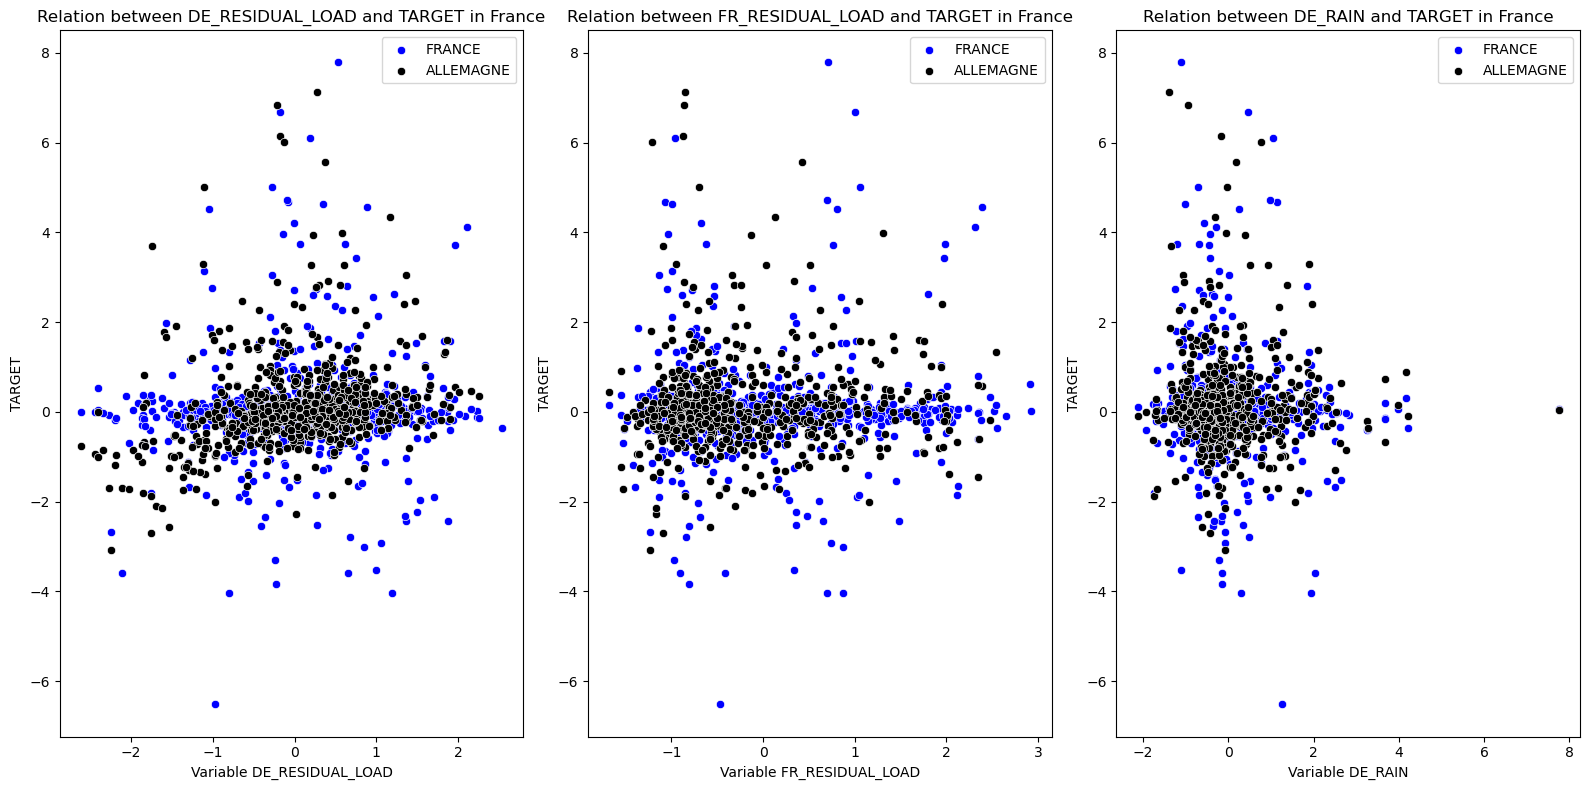

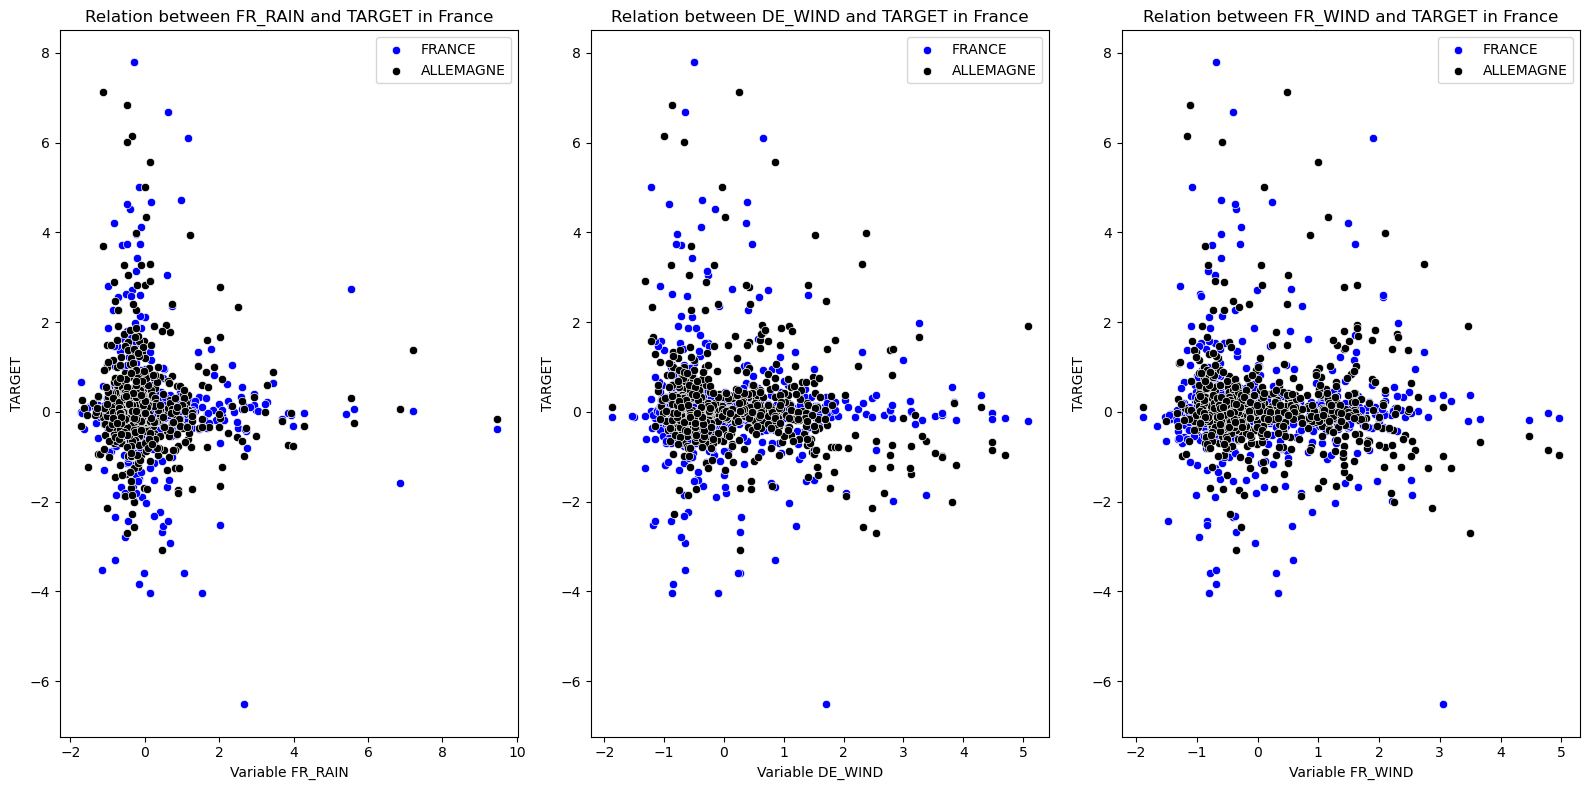

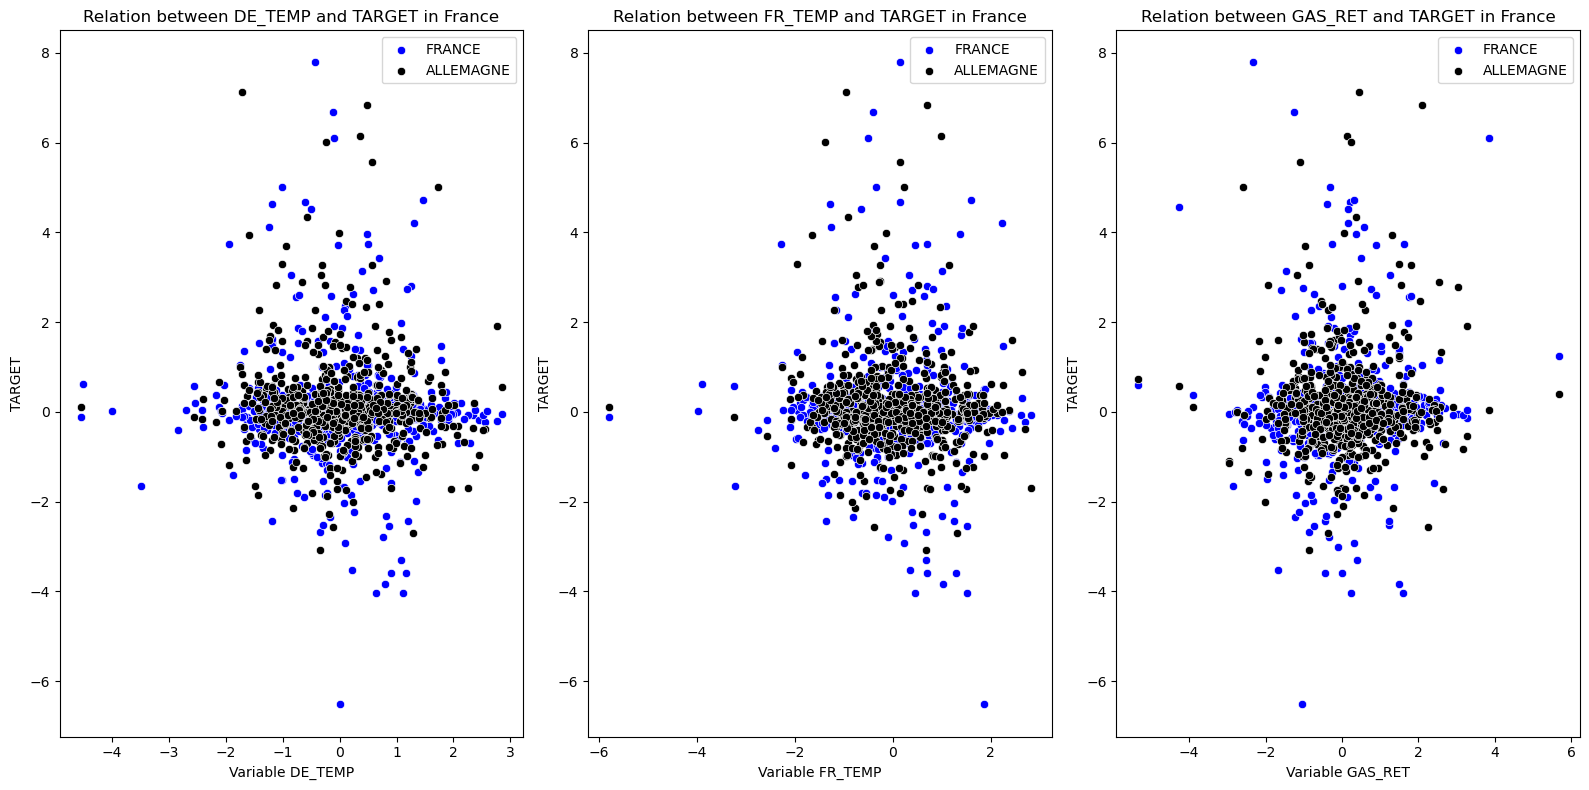

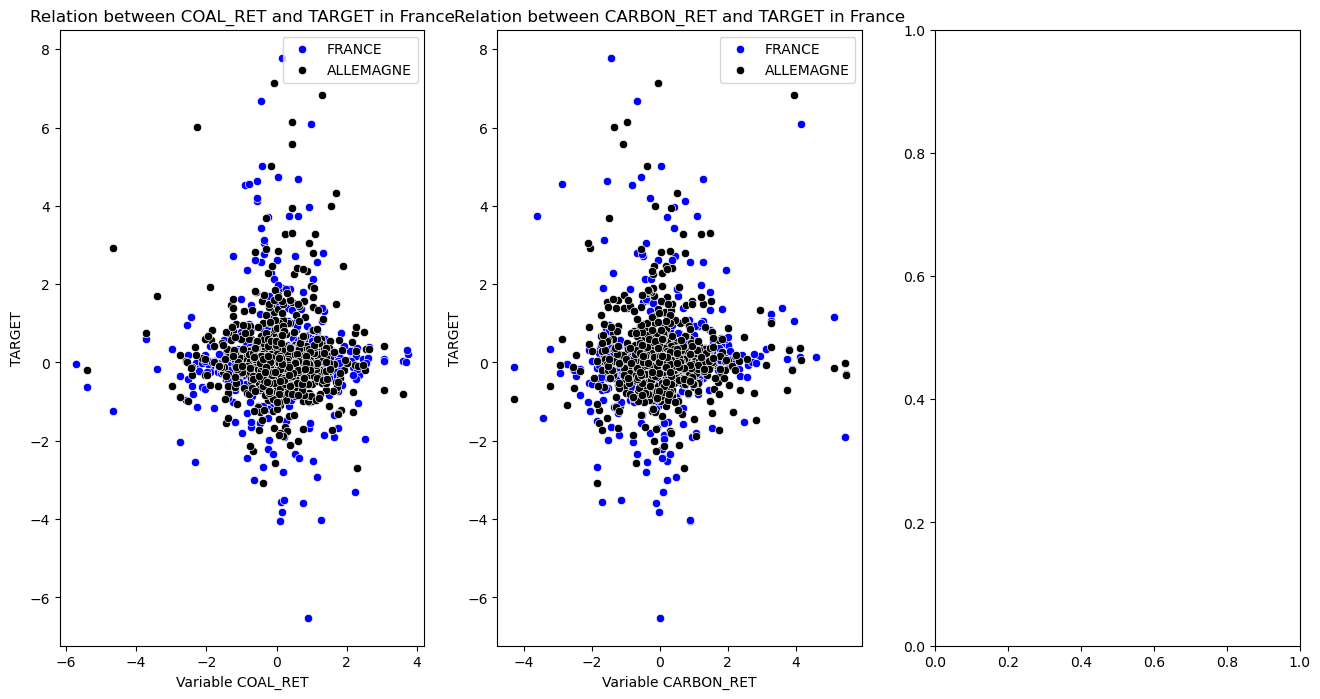

In [9]:
df_train = pd.merge(X_train,y_train, on = 'ID', how='inner')
pays = list(df_train['COUNTRY'].unique())
df_train_france = df_train[df_train['COUNTRY'] == 'FR']
df_train_allemagne = df_train[df_train['COUNTRY'] == 'DE']

# visualiser la relation entre les variables et target : 

fig, axes = plt.subplots(1, 3, figsize=(16, 8))
axe = 0

for i, col in enumerate(float_variables):
    if axe>2:
        plt.tight_layout()
        plt.show()
        fig, axes = plt.subplots(1, 3, figsize=(16, 8))
        axe=0

    sns.scatterplot(x=df_train_france[col], y=df_train_france['TARGET'], color = 'blue',ax=axes[axe], label = 'FRANCE')
    sns.scatterplot(x=df_train_allemagne[col], y=df_train_allemagne['TARGET'], color = 'black',ax=axes[axe], label = "ALLEMAGNE")
    axes[axe].set_xlabel(f'Variable {col}')
    axes[axe].set_ylabel('TARGET')
    axes[axe].set_title(f'Relation between {col} and TARGET in France')
    axe += 1

/Users/augustincablant/opt/anaconda3/lib/python3.9/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/Users/augustincablant/opt/anaconda3/lib/python3.9/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


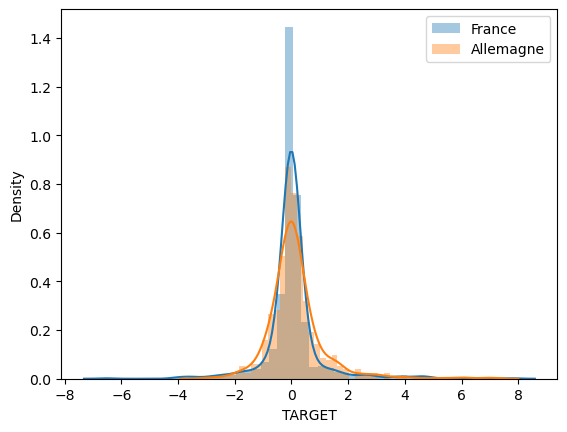

In [10]:
# Relation entre pays et target 
plt.figure()
sns.distplot(df_train_france['TARGET'], label = 'France')
sns.distplot(df_train_allemagne['TARGET'], label = 'Allemagne')
plt.legend()
plt.show()

<AxesSubplot:>

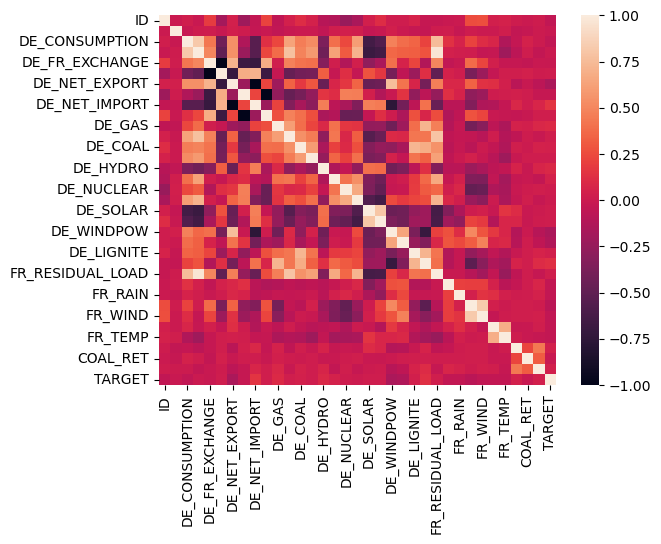

In [11]:
sns.heatmap(df_train.corr())

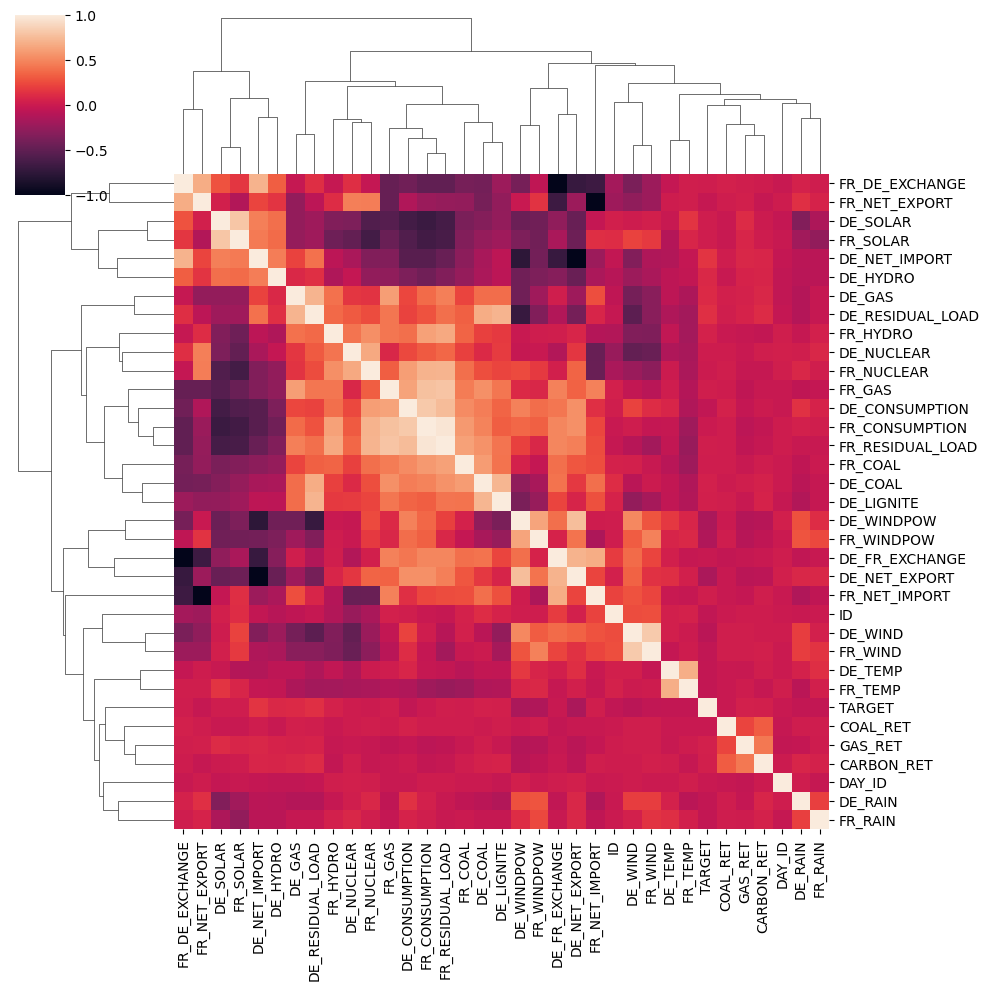

In [12]:
sns.clustermap(df_train.corr())

In [13]:
df_train.corr()['TARGET'].sort_values()

DE_NET_EXPORT      -0.154301
DE_WINDPOW         -0.150287
FR_WINDPOW         -0.132523
DE_WIND            -0.084127
DE_CONSUMPTION     -0.052565
FR_WIND            -0.050216
ID                 -0.048030
FR_TEMP            -0.046516
DE_TEMP            -0.044189
FR_RAIN            -0.040926
DE_RAIN            -0.040206
FR_NET_EXPORT      -0.025213
DE_FR_EXCHANGE     -0.020330
DAY_ID             -0.011612
COAL_RET           -0.010285
FR_CONSUMPTION     -0.005685
FR_NUCLEAR          0.001588
DE_NUCLEAR          0.012236
FR_COAL             0.015732
FR_DE_EXCHANGE      0.020330
FR_SOLAR            0.021081
DE_SOLAR            0.021934
FR_GAS              0.024652
FR_NET_IMPORT       0.025213
FR_RESIDUAL_LOAD    0.030254
DE_LIGNITE          0.034433
CARBON_RET          0.038252
GAS_RET             0.041969
DE_COAL             0.045181
FR_HYDRO            0.052820
DE_HYDRO            0.086127
DE_GAS              0.096657
DE_RESIDUAL_LOAD    0.132555
DE_NET_IMPORT       0.154301
TARGET        

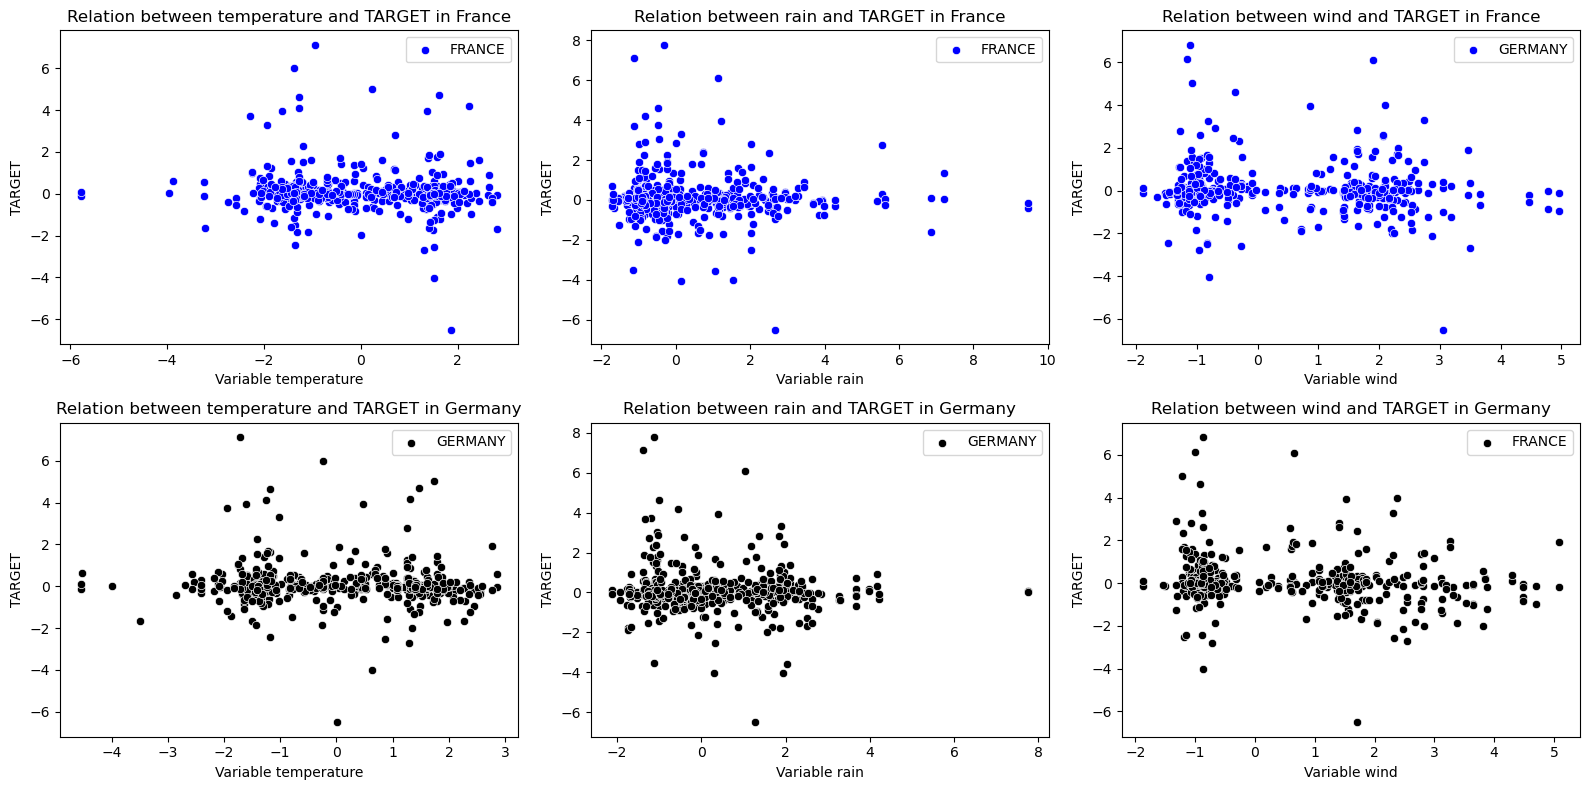

In [20]:
## Nous pouvons faire l'hypothèse que les colonnes météo ne sont importantes que si les températures, la pluie ou le vent sont extrêmes. 
## C'est pourquoi nous visualisons l'effet de ces météo extrêmes sur la variable target 
df_temp = df_train[(df_train['DE_TEMP'] <= df_train['DE_TEMP'].quantile(0.10))|(df_train['DE_TEMP'] >= df_train['DE_TEMP'].quantile(0.90))|
                   (df_train['FR_TEMP'] >= df_train['FR_TEMP'].quantile(0.90))|(df_train['FR_TEMP'] <= df_train['FR_TEMP'].quantile(0.10))]

df_rain = df_train[(df_train['DE_RAIN'] <= df_train['DE_RAIN'].quantile(0.10))|(df_train['DE_RAIN'] >= df_train['DE_RAIN'].quantile(0.90))|
                   (df_train['FR_RAIN'] >= df_train['FR_RAIN'].quantile(0.90))|(df_train['FR_RAIN'] <= df_train['FR_RAIN'].quantile(0.10))]

df_wind = df_train[(df_train['DE_WIND'] <= df_train['DE_WIND'].quantile(0.10))|(df_train['DE_WIND'] >= df_train['DE_WIND'].quantile(0.90))|
                   (df_train['FR_WIND'] >= df_train['FR_WIND'].quantile(0.90))|(df_train['FR_WIND'] <= df_train['FR_WIND'].quantile(0.10))]





# visualiser la relation entre les variables et target : 

fig, axes = plt.subplots(2, 3, figsize=(16, 8))

sns.scatterplot(x = df_temp['FR_TEMP'], y = df_temp['TARGET'], color = 'blue', ax = axes[0,0], label = 'FRANCE')
axes[0,0].set_xlabel('Variable temperature')
axes[0,0].set_ylabel('TARGET')
axes[0,0].set_title(f'Relation between temperature and TARGET in France')

sns.scatterplot(x = df_temp['DE_TEMP'], y = df_temp['TARGET'], color = 'black', ax = axes[1,0], label = 'GERMANY')
axes[1,0].set_xlabel(f'Variable temperature')
axes[1,0].set_ylabel('TARGET')
axes[1,0].set_title(f'Relation between temperature and TARGET in Germany')
## 
sns.scatterplot(x = df_rain['FR_RAIN'], y = df_rain['TARGET'], color = 'blue', ax = axes[0,1], label = 'FRANCE')
axes[0,1].set_xlabel('Variable rain')
axes[0,1].set_ylabel('TARGET')
axes[0,1].set_title(f'Relation between rain and TARGET in France')

sns.scatterplot(x = df_rain['DE_RAIN'], y = df_rain['TARGET'], color = 'black', ax = axes[1,1], label = 'GERMANY')
axes[1,1].set_xlabel(f'Variable rain')
axes[1,1].set_ylabel('TARGET')
axes[1,1].set_title(f'Relation between rain and TARGET in Germany')
##
sns.scatterplot(x = df_wind['FR_WIND'], y = df_wind['TARGET'], color = 'blue', ax = axes[0,2], label = 'GERMANY')
axes[0,2].set_xlabel('Variable wind')
axes[0,2].set_ylabel('TARGET')
axes[0,2].set_title(f'Relation between wind and TARGET in France')

sns.scatterplot(x = df_wind['DE_WIND'], y = df_wind['TARGET'], color = 'black', ax = axes[1,2], label = 'FRANCE')
axes[1,2].set_xlabel(f'Variable wind')
axes[1,2].set_ylabel('TARGET')
axes[1,2].set_title(f'Relation between wind and TARGET in Germany')
##

plt.tight_layout()
plt.show()


La France et l'Allemagne sont deux pays différents. En regardant simplement leur politique (fortement divergente) concernant le nucléaire, on tire vite des conclusions : nous ne pouvons traiter ces deux pays ensemble, il nous faut créer un modèle propre à chaque pays. 

In [15]:
X_train_all = X_train[X_train['COUNTRY']=='DE']
X_train_fr = X_train[X_train['COUNTRY']=='FR']